In [1]:
import numpy as np
import glob
import os
%matplotlib inline
from readTRC import readTrc
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chisquare
import numpy.polynomial.polynomial as poly


import matplotlib.mlab as mlab
from scipy import optimize
from scipy.special import erf
import os
import numpy.polynomial.polynomial as poly
from collections import OrderedDict

In [2]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
def FILE_SORTER(files):
    FilesGold   = []
    FilesSignal = []
    for x in range(0,len(files)):
        if int(files[x][1]) ==4 or int(files[x][1]) ==2:
            FilesGold.append(files[x])
        if int(files[x][1]) ==3 or int(files[x][1]) ==1:
            FilesSignal.append(files[x])
            
    FilesGold.sort(); FilesSignal.sort()
    return FilesGold, FilesSignal

def MEAN_WAVEFORM(PATH,files):
    #folders[F]+FilesSignal[0]
    #X, Y, info = readTrc(PATH+files[10])
    #Yvals = np.zeros(X.shape[0])
    #Xvals = np.zeros(Y.shape[0])
    Yvals = np.zeros(10002)
    Xvals = np.zeros(10002)
    avg = 0
    for w in range(0,len(files)):

        X, Y, info = readTrc(PATH+files[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            Yvals += Y
            Xvals += X
            avg   += 1
    MSigY = Yvals/avg
    MSigX = Xvals/avg
    return MSigX,MSigY

def WAVEFORM_QUALITY(PATH,files,MEAN,CHI):
    
    #X, Y, info = readTrc(PATH+files[10])
    #Yvals = np.zeros(X.shape[0])
    #Xvals = np.zeros(Y.shape[0])
    Yvals = np.zeros(10002)
    Xvals = np.zeros(10002)
    avg = 0
    #for w in range(0,1100):
    CHII = []
    for w in range(0,len(files)):

        X, Y, info = readTrc(PATH+files[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            A = moving_average(MEAN,10)
            B = moving_average(Y   ,10)
            D = moving_average(X   ,10)
            TriggerTime = find_nearest(D,0)
            Trigger     = np.where(D==TriggerTime)[0][0]
            As    = np.mean(A[:Trigger])
            Bs    = np.mean(B[:Trigger])
            
            holder = ((A-As)-(B-Bs))**2
            chi = np.sum(holder)*1e4
            if chi <CHI:
                Yvals += Y
                Xvals += X
                avg   += 1
                CHII.append(chi)
        if avg != 0:
            SigY = Yvals/avg
            SigX = Xvals/avg
        else:
            SigY = Yvals
            SigX = Xvals 
        
    #CHI=np.array(CHI)
    return SigX,SigY,CHII

In [4]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def FIND_MAX(X,Y):
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+5
    xx = moving_average(X,20)
    yy = moving_average(Y,20)
    
    xxx = xx[Trigger:]
    yyy = yy[Trigger:]
    
    maxy = max(yyy)
    
    hold      = find_nearest(yyy,maxy)
    peak     = np.where(yyy==hold)[0][0]

    xxx = xx[Trigger:Trigger+peak]
    yyy = yy[Trigger:Trigger+peak]
    
    hold      = find_nearest(yyy,maxy*0.1)
    edge     = np.where(yyy==hold)[0][0]
    return Trigger+peak, Trigger+edge

def FIND_MIN(X,Y):
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+20
    xx = moving_average(X,20)
    yy = moving_average(Y,20)
    
    xxx = xx[Trigger:]
    yyy = yy[Trigger:]
    
    miny = min(yyy)
    
    hold      = find_nearest(yyy,miny)
    MINLOC     = np.where(yyy==hold)[0][0]
    
    TT = Trigger+MINLOC
    xxxx = xx[Trigger:TT]
    yyyy = yy[Trigger:TT]
    
    hold      = find_nearest(yyyy,miny*0.1)
    REDGE     = np.where(yyyy==hold)[0][0]
    return MINLOC+Trigger,miny,REDGE+Trigger

def funcG(t,t0,sig,a,c):
    tau = 121e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E

def funcA(t,t0,sig,a,c):
    tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E
def func(t,t0,sig,a,c,tau):
    #tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E

def FITTER_GOLD(x,y):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)

    xx = moving_average(XX,20)
    yy = moving_average(YY,20)

    xxx = xx[Trigger:]
    yyy = yy[Trigger:]

    miny = max(yyy)

    hold      = find_nearest(yyy,miny)
    MINLOC     = np.where(yyy==hold)[0][0]

    TT = Trigger+MINLOC
    TT = int(TT)

    xxxx = xx[Trigger:TT]
    yyyy = yy[Trigger:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = Trigger+REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 400
    cut2=cut-100
    fitX = XX[Arr-cut2:Arr+cut]
    fitY = YY[Arr-cut2:Arr+cut]

    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=fitval)

    chi = sum((funcG(fitX,*optim)- fitY)**2)
    return XX,YY,optim,chi

def FITTER_ANOD(x,y):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)
    XX = XX[Trigger:]
    YY = YY[Trigger:]

    xx = moving_average(XX,20)
    yy = moving_average(YY,20)

    xxx = xx[Trigger:]
    yyy = yy[Trigger:]

    miny = min(yy)

    hold      = find_nearest(yy,miny)
    MINLOC     = np.where(yy==hold)[0][0]

    TT = MINLOC
    TT = int(TT)

    xxxx = xx[:TT]
    yyyy = yy[:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 400
    cut2=cut-50
    if XX[Arr-cut2:Arr+cut].shape[0]!=0:
        fitX = XX[Arr-cut2:Arr+cut]
        fitY = YY[Arr-cut2:Arr+cut]
    else:
        fitX = XX[0:Arr+cut]
        fitY = YY[0:Arr+cut]


    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=fitval)

    chi = sum((funcA(fitX,*optim)- fitY)**2)
    return XX,YY,optim,chi

In [5]:
FOLD = ['100/','035/','015/','008/','002/','000/']
SPATH = '/Users/austinmcdonald/Desktop/XeAr/Data/'+FOLD[0]
PATH = '/Users/austinmcdonald/Desktop/XeAr/'+FOLD[0]
folders = glob.glob(PATH+"*/")
folders.sort()
#folders

Xe-100_P-01_E-080
OPT high G =  [8.76043940e-06 1.63348687e-06 2.19849681e-03 1.82953795e-04]
OPT high S =  [ 1.54668375e-04  6.04727792e-06 -1.24640028e-04  7.86956955e-06]
G chi =  1.1207097860350406
A chi =  0.13421172561339503
OPT low G =  [8.76085240e-06 1.59569928e-06 2.19956755e-03 1.51643772e-04]
OPT low S =  [ 1.55242707e-04  5.79183514e-06 -1.19438722e-04  6.99258171e-06]
G chi =  1.373682975268887
A chi =  0.2602701988047302


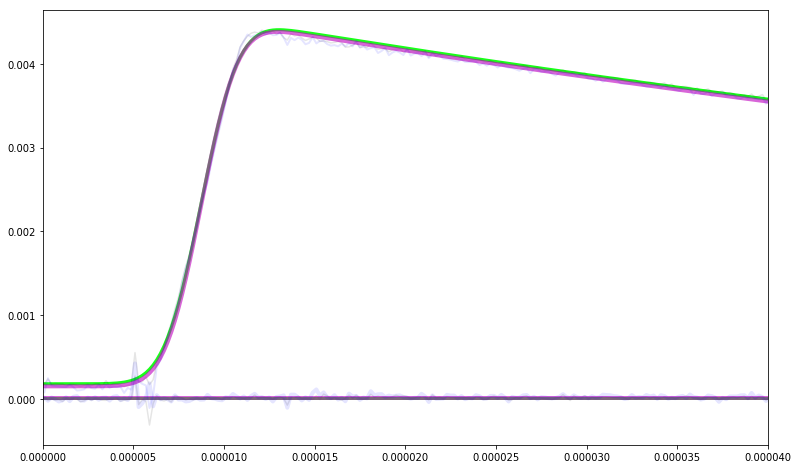

Xe-100_P-01_E-100
OPT high G =  [8.76107498e-06 1.60476730e-06 2.21717390e-03 1.10604559e-04]
OPT high S =  [ 1.50051646e-04  5.74062352e-06 -1.50630652e-04  2.37254468e-06]
G chi =  1.2948339782179057
A chi =  0.15363098075824094
OPT low G =  [8.75518427e-06 1.62306098e-06 2.21343238e-03 1.00616140e-04]
OPT low S =  [ 1.50594121e-04  6.06503350e-06 -1.47561715e-04  7.97817047e-06]
G chi =  1.3075138931167976
A chi =  0.3408215906672882


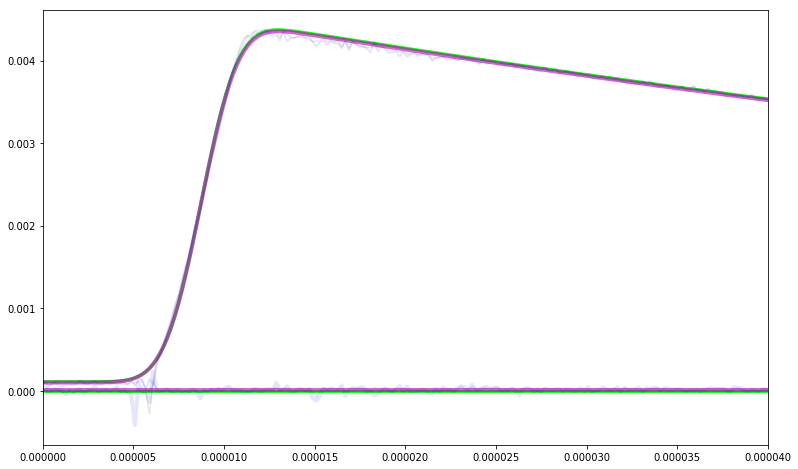

Xe-100_P-01_E-150
OPT high G =  [ 8.73032427e-06  1.62614061e-06  2.20145483e-03 -2.66486147e-04]
OPT high S =  [ 1.40079268e-04  4.98979029e-06 -2.87072454e-04  1.51081329e-05]
G chi =  1.673731260688057
A chi =  0.1943941034716844
OPT low G =  [ 8.75017318e-06  1.64062520e-06  2.20326535e-03 -2.64708402e-04]
OPT low S =  [ 1.40361145e-04  5.19495928e-06 -2.93477119e-04  1.94358865e-05]
G chi =  1.8910060492799659
A chi =  0.6970955345061932


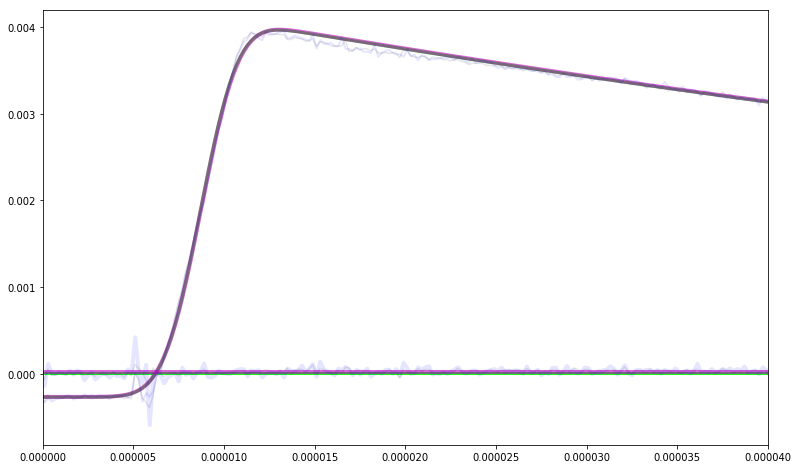

Xe-100_P-01_E-200
OPT high G =  [ 8.69666721e-06  1.65813391e-06  2.20602364e-03 -6.90010988e-04]
OPT high S =  [ 1.33032779e-04  4.76833546e-06 -4.26740145e-04  1.16973680e-05]
G chi =  2.2081316435728064
A chi =  0.1905388640828011
OPT low G =  [ 8.60870871e-06  1.72461708e-06  2.21437638e-03 -6.90893730e-04]
OPT low S =  [ 1.33156053e-04  4.73773386e-06 -4.27965682e-04  1.12785340e-05]
G chi =  7.806151291758783
A chi =  0.8493100672590121


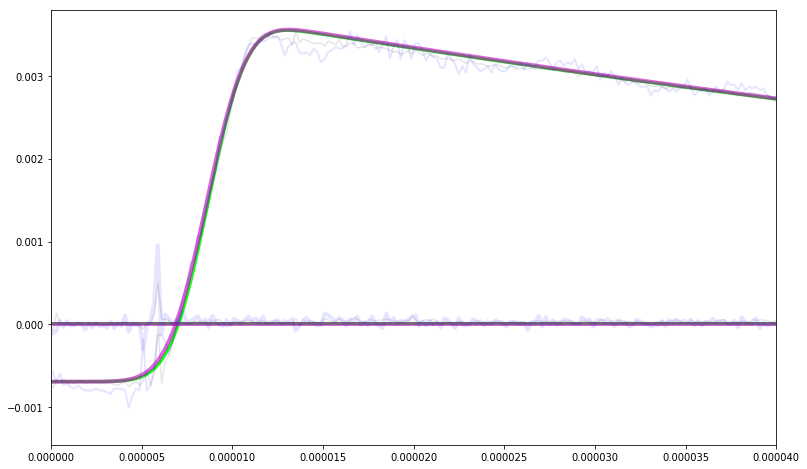

Xe-100_P-01_E-250
OPT high G =  [ 8.68664628e-06  1.66452525e-06  2.22498169e-03 -1.36614369e-03]
OPT high S =  [ 1.27592303e-04  4.38440645e-06 -5.47661967e-04  5.39771160e-06]
G chi =  2.549979562490491
A chi =  0.32451032453532674


/Users/austinmcdonald/miniconda/envs/IC-3.6-2018-11-14/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
/Users/austinmcdonald/miniconda/envs/IC-3.6-2018-11-14/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide
/Users/austinmcdonald/miniconda/envs/IC-3.6-2018-11-14/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


OPT low G =  [0.         0.         0.00236491 0.00236491]
OPT low S =  [ 0.00000000e+00  0.00000000e+00 -9.88037403e-04 -6.13107022e-05]
G chi =  nan
A chi =  nan


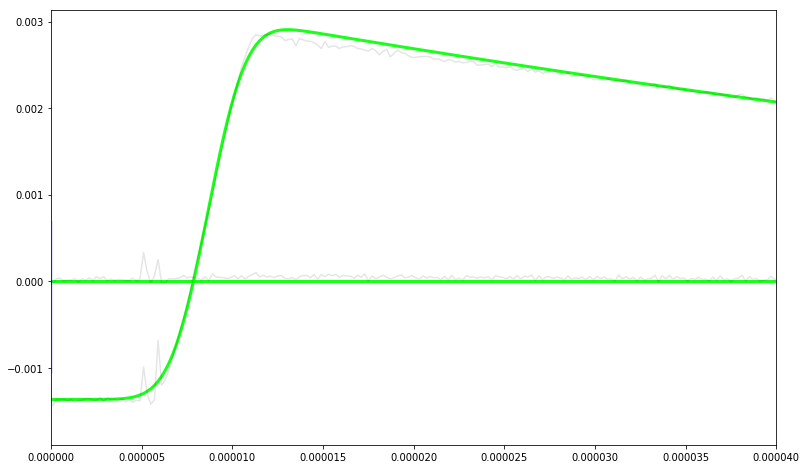

Xe-100_P-01_E-300
OPT high G =  [ 8.68299558e-06  1.66132714e-06  2.25976562e-03 -2.41966704e-03]
OPT high S =  [ 1.23199053e-04  4.00369980e-06 -6.85366042e-04  3.00883314e-05]
G chi =  3.8130291305555577
A chi =  0.3125160648623967
OPT low G =  [0.         0.         0.00273534 0.00273534]
OPT low S =  [ 0.00000000e+00  0.00000000e+00 -1.19356973e-03 -6.67835028e-05]
G chi =  nan
A chi =  nan


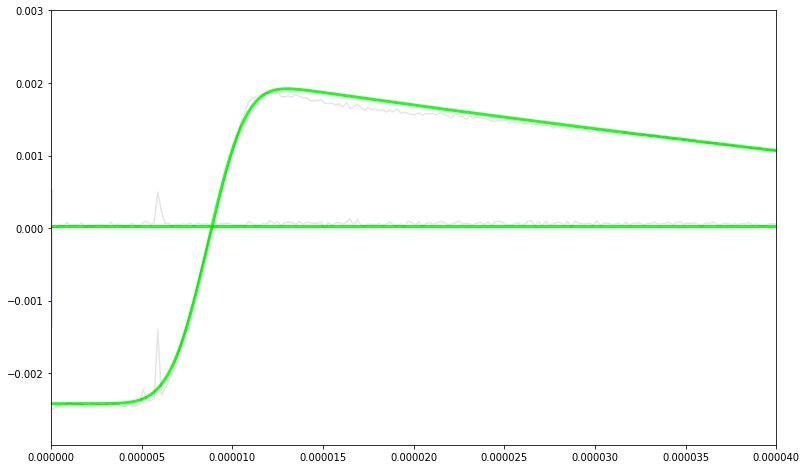

Xe-100_P-03_E-080
OPT high G =  [9.36606920e-06 1.93402899e-06 1.46985972e-03 6.17751467e-05]
OPT high S =  [ 1.84798761e-04  6.57522091e-06 -1.69695850e-04 -1.18895703e-05]
G chi =  0.7464985530725168
A chi =  0.22403971043989507
OPT low G =  [9.37686464e-06 1.95514193e-06 1.47269329e-03 2.11490979e-05]
OPT low S =  [ 1.84427689e-04  6.54060240e-06 -1.68722682e-04 -1.56797626e-05]
G chi =  1.1801923011255775
A chi =  0.3511867716821612


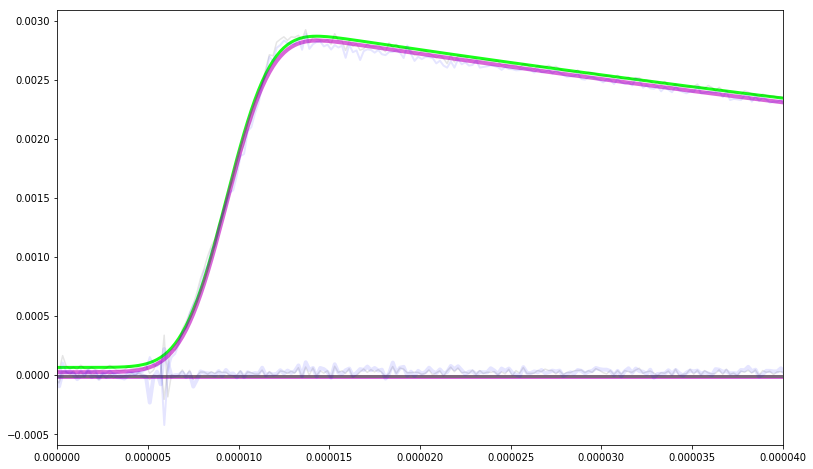

Xe-100_P-03_E-100
OPT high G =  [9.31278358e-06 1.93138023e-06 1.47070240e-03 2.67184995e-05]
OPT high S =  [ 1.76652162e-04  6.63698413e-06 -2.13207466e-04  1.12456368e-05]
G chi =  0.7851965273803937
A chi =  0.2229419602720436
OPT low G =  [9.31613915e-06 1.93734286e-06 1.47148683e-03 2.98288304e-05]
OPT low S =  [ 1.76613520e-04  6.57266254e-06 -2.08081402e-04  7.17123725e-06]
G chi =  0.7770840727851753
A chi =  0.3638433859200534


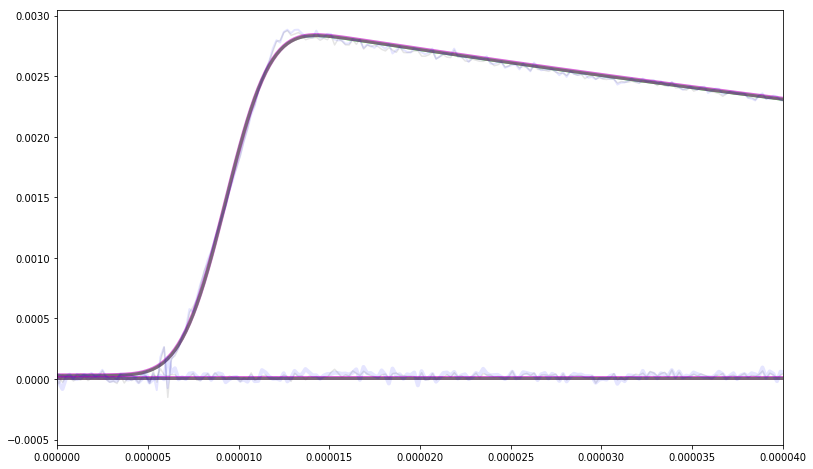

Xe-100_P-03_E-150
OPT high G =  [ 9.28912024e-06  1.96364883e-06  1.46947061e-03 -3.72762276e-04]
OPT high S =  [ 1.66132866e-04  5.83779377e-06 -3.35405215e-04  7.06344632e-06]
G chi =  0.8449672740549676
A chi =  0.21327020085288614
OPT low G =  [ 9.26353336e-06  1.99239395e-06  1.47266744e-03 -5.02434244e-04]
OPT low S =  [ 1.65971031e-04  5.86772196e-06 -3.38069021e-04 -3.40350164e-06]
G chi =  1.6259344389396322
A chi =  0.5618483785126566


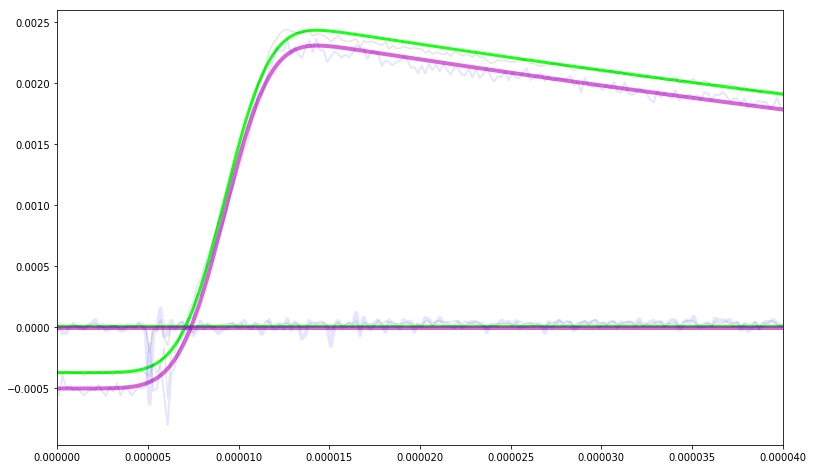

Xe-100_P-03_E-200
OPT high G =  [ 9.22790432e-06  1.97965652e-06  1.46585984e-03 -9.10564870e-04]
OPT high S =  [ 1.59155215e-04  5.59764766e-06 -4.53795602e-04  1.83199370e-06]
G chi =  0.9064467319363442
A chi =  0.24777641887214397
OPT low G =  [ 9.40133393e-06  1.88421580e-06  1.50863386e-03 -1.09003429e-03]
OPT low S =  [ 1.59126073e-04  5.37497086e-06 -4.44009852e-04 -9.28673906e-06]
G chi =  23.759481463331195
A chi =  0.8359407169297102


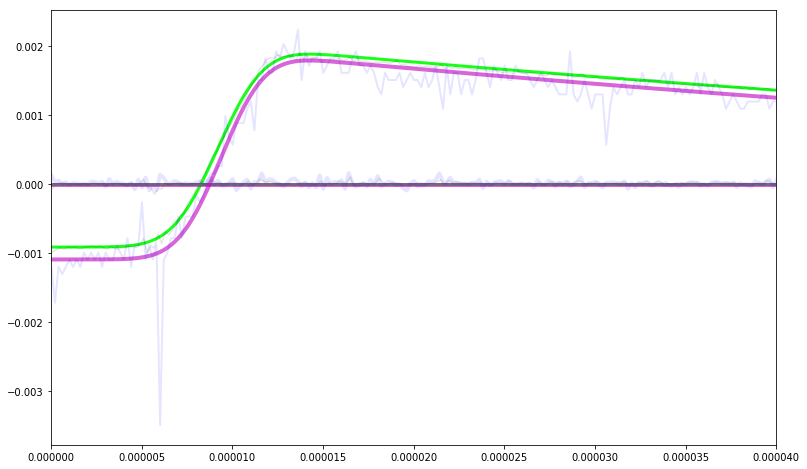

Xe-100_P-03_E-250
OPT high G =  [ 9.24197837e-06  1.95968272e-06  1.47134132e-03 -1.46413339e-03]
OPT high S =  [ 1.53741265e-04  5.21902648e-06 -5.43136277e-04  1.59545834e-05]
G chi =  1.093329508499026
A chi =  0.2807850560062563
OPT low G =  [0.         0.         0.00227587 0.00227587]
OPT low S =  [ 0.00000000e+00  0.00000000e+00 -9.52329079e-04 -5.09634000e-05]
G chi =  nan
A chi =  nan


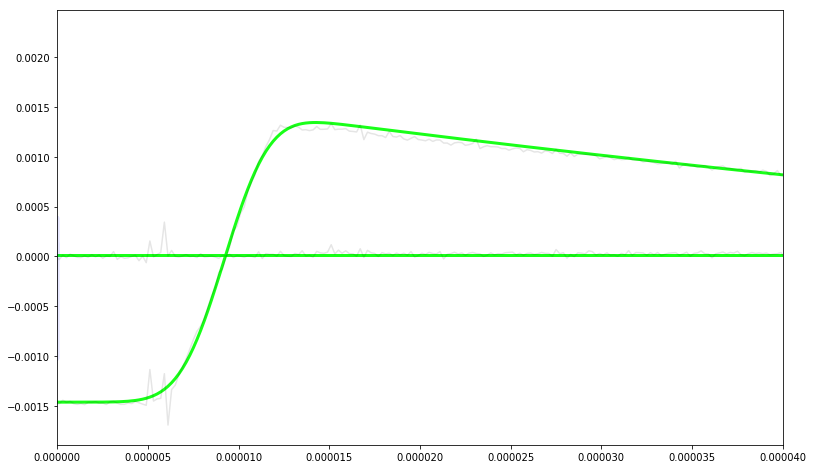

Xe-100_P-03_E-300
OPT high G =  [ 9.16724065e-06  2.02796380e-06  1.50722332e-03 -2.59110109e-03]
OPT high S =  [ 1.49517427e-04  4.86823239e-06 -6.41883558e-04 -7.06476118e-06]
G chi =  1.9672885694074225
A chi =  0.26147475487832605
OPT low G =  [0.         0.         0.00260608 0.00260608]
OPT low S =  [ 0.00000000e+00  0.00000000e+00 -1.21474986e-03 -8.20307011e-05]
G chi =  nan
A chi =  nan


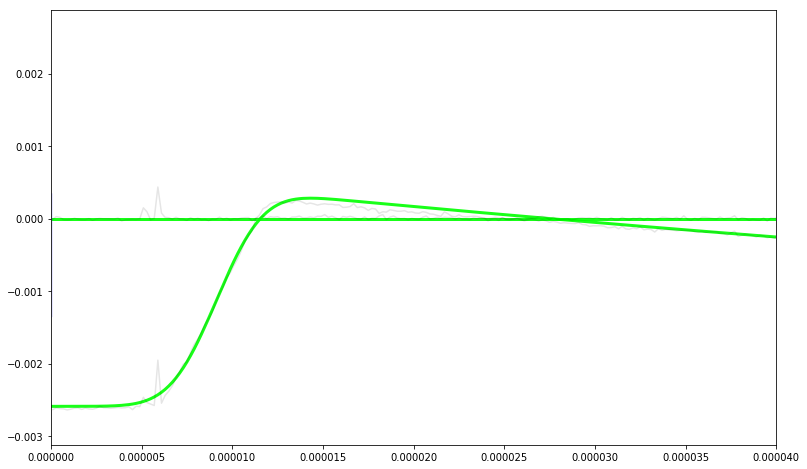

Xe-100_P-06_E-080
OPT high G =  [9.68625466e-06 2.11700767e-06 1.14661999e-03 7.92791186e-05]
OPT high S =  [ 2.83551289e-04  1.23405638e-05 -2.47430612e-04  2.95785426e-06]
G chi =  0.5383463158961281
A chi =  0.22943142473878333
OPT low G =  [9.70566962e-06 2.05895076e-06 1.15178675e-03 9.26962417e-05]
OPT low S =  [ 2.83343705e-04  1.19425287e-05 -2.45827400e-04 -3.32553086e-06]
G chi =  1.0997963085915383
A chi =  0.2976101368414459


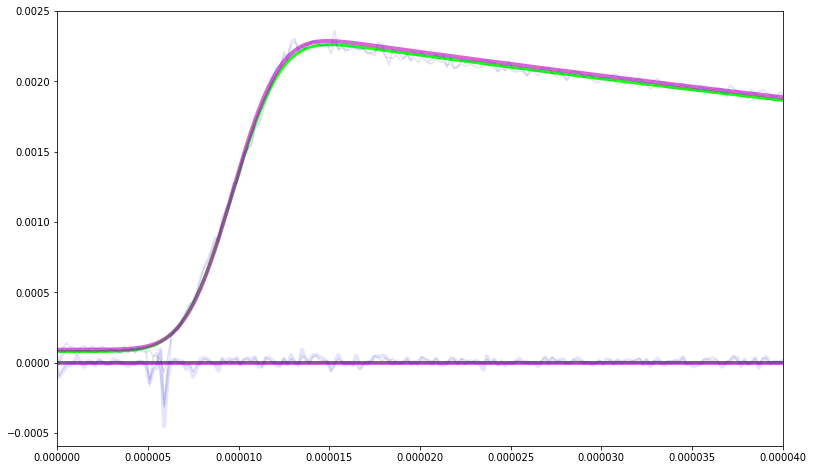

Xe-100_P-06_E-100
OPT high G =  [ 9.70092967e-06  2.10274326e-06  1.14545578e-03 -1.72187917e-05]
OPT high S =  [ 2.22527896e-04  8.42560535e-06 -2.70846850e-04  4.39235965e-06]
G chi =  0.8132903279231948
A chi =  0.16582600308625944
OPT low G =  [ 9.73514638e-06  2.07600797e-06  1.14437302e-03 -6.67146449e-05]
OPT low S =  [ 2.22415693e-04  8.56671573e-06 -2.74996636e-04  1.46555529e-05]
G chi =  1.1210147439326508
A chi =  0.3534253994196092


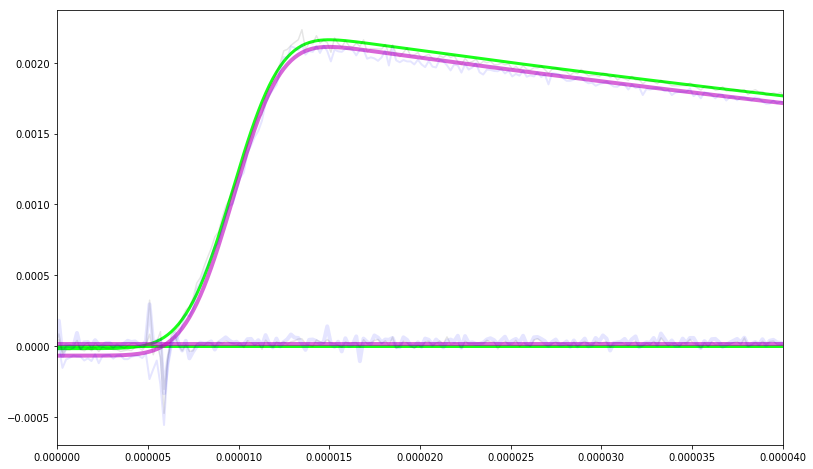

Xe-100_P-06_E-150
OPT high G =  [ 9.66040631e-06  2.16727573e-06  1.13719257e-03 -3.21344639e-04]
OPT high S =  [ 1.86033394e-04  6.55297375e-06 -3.77365220e-04  1.28546507e-05]
G chi =  0.6388795435674899
A chi =  0.4655465006967363
OPT low G =  [ 9.65624922e-06  2.09921620e-06  1.14135061e-03 -3.31319068e-04]
OPT low S =  [ 1.85873703e-04  6.37674723e-06 -3.71678183e-04  1.17216784e-05]
G chi =  2.009552572298052
A chi =  1.0263478651958615


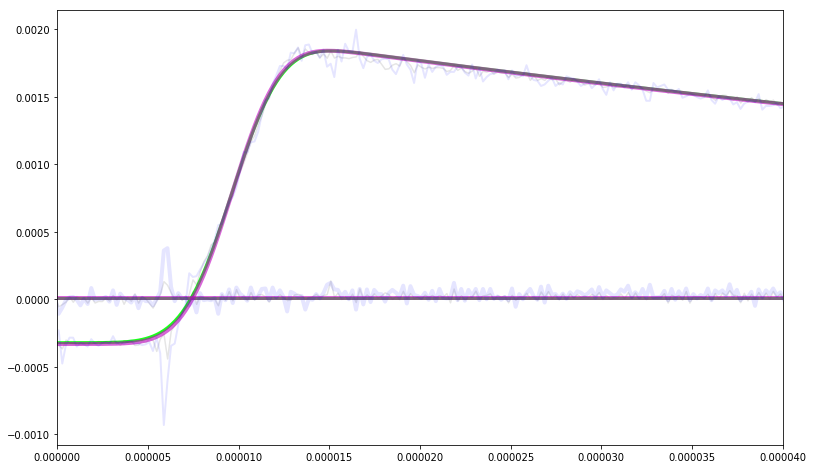

Xe-100_P-06_E-200
OPT high G =  [ 9.58641207e-06  2.13111281e-06  1.14126605e-03 -7.66838974e-04]
OPT high S =  [ 1.75791930e-04  6.08724341e-06 -4.57531000e-04  1.10073884e-05]
G chi =  0.8067721265189332
A chi =  0.267479989831157
OPT low G =  [0.         0.         0.00202838 0.00202838]
OPT low S =  [ 0.00000000e+00  0.00000000e+00 -7.80115041e-04 -4.10436977e-05]
G chi =  nan
A chi =  nan


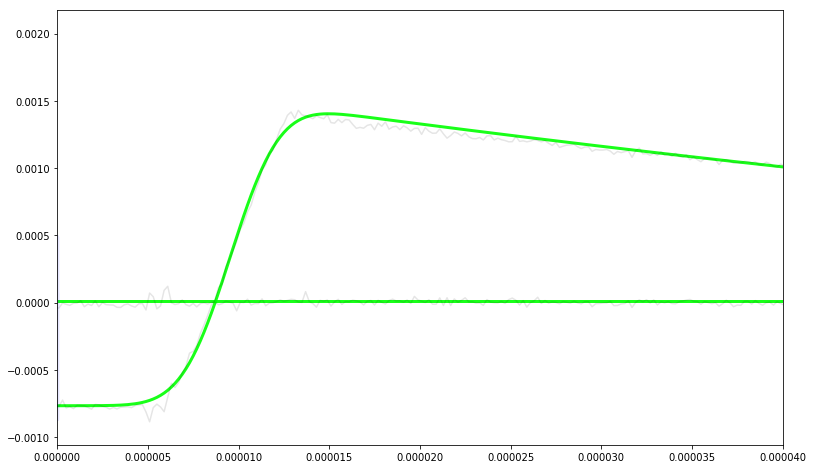

Xe-100_P-06_E-250
OPT high G =  [ 9.56743674e-06  2.16425241e-06  1.13800861e-03 -1.46664702e-03]
OPT high S =  [ 1.70007087e-04  5.73059957e-06 -5.25294894e-04  7.70550792e-06]
G chi =  1.2660109971378304
A chi =  0.2453324706850409
OPT low G =  [0.         0.         0.00238281 0.00238281]
OPT low S =  [ 0.00000000e+00  0.00000000e+00 -9.31424025e-04 -4.72724157e-05]
G chi =  nan
A chi =  nan


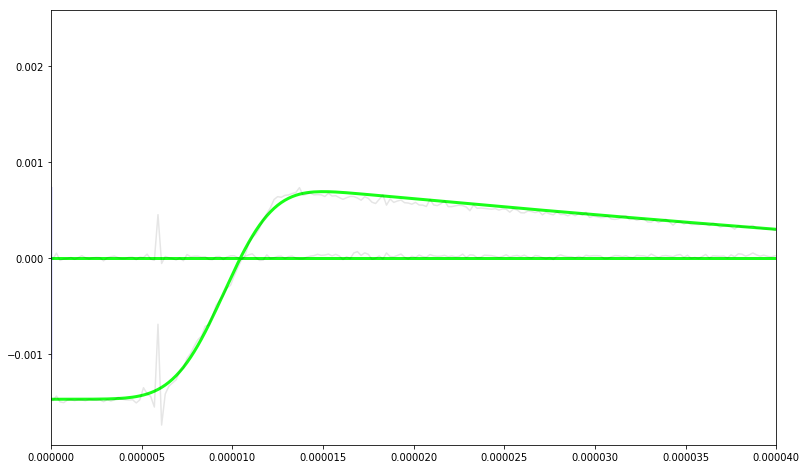

Xe-100_P-06_E-300
OPT high G =  [ 9.48991971e-06  2.24305610e-06  1.19743679e-03 -2.52628541e-03]
OPT high S =  [ 1.65767817e-04  5.18306831e-06 -5.84872369e-04 -3.04680224e-06]
G chi =  1.471089055595952
A chi =  0.3767396975085168


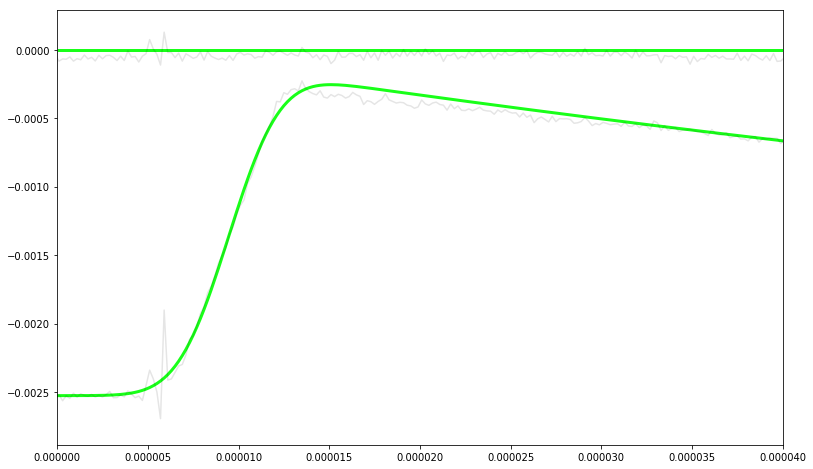

Xe-100_P-09_E-080
OPT high G =  [1.01079554e-05 2.48848241e-06 9.75213292e-04 1.53399365e-04]
OPT high S =  [ 6.43275236e-04  2.50639629e-05 -1.20692079e-04  7.84694087e-07]
G chi =  0.4990137554251225
A chi =  0.14924446251811663
OPT low G =  [1.01113383e-05 2.49334662e-06 9.71841524e-04 1.19354930e-04]
OPT low S =  [ 6.41784266e-04  2.57410031e-05 -1.22697865e-04  7.36513198e-06]
G chi =  0.7896810093950022
A chi =  0.3256882503652462


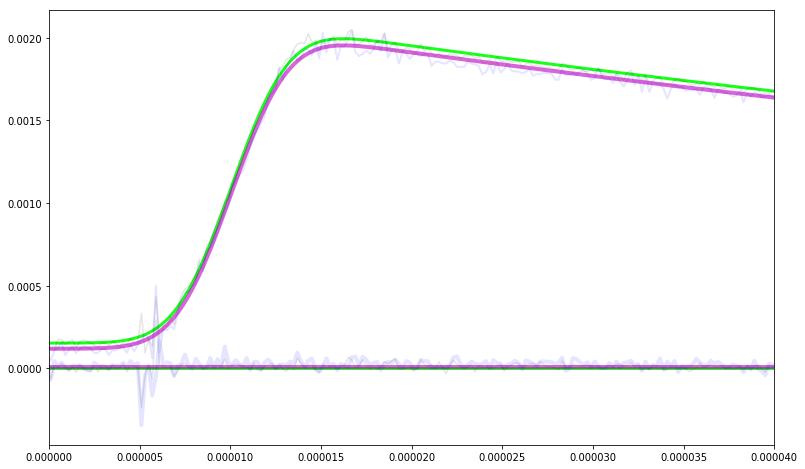

Xe-100_P-09_E-100
OPT high G =  [1.01541727e-05 2.44580126e-06 9.74611062e-04 9.67540313e-05]
OPT high S =  [ 3.95814990e-04  1.49921612e-05 -2.20537609e-04  5.79002100e-06]
G chi =  0.6229173206595986
A chi =  0.27002067817424796
OPT low G =  [1.01204825e-05 2.46384391e-06 9.77564393e-04 6.06045731e-05]
OPT low S =  [ 2.07762846e-04  1.47982953e-08 -5.18254728e-06  3.72187637e-06]
G chi =  1.240979535056491
A chi =  0.8912146208414258


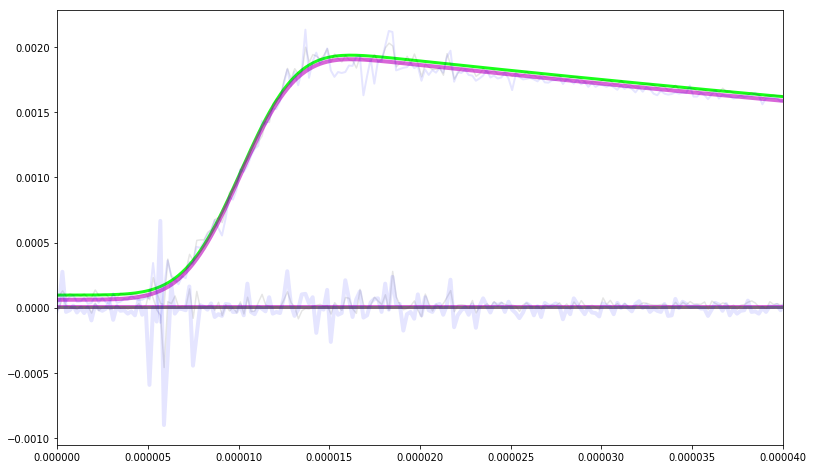

Xe-100_P-09_E-150
OPT high G =  [ 1.00818069e-05  2.38430199e-06  9.84149836e-04 -3.51980338e-04]
OPT high S =  [ 2.25249668e-04  7.97275629e-06 -3.77403918e-04  8.97597723e-06]
G chi =  0.4778461083337101
A chi =  0.2298717775348476
OPT low G =  [ 1.00937820e-05  2.40755940e-06  9.87475573e-04 -4.64508461e-04]
OPT low S =  [ 2.25410555e-04  7.86168601e-06 -3.86599526e-04  2.62141375e-05]
G chi =  1.8818946098663414
A chi =  0.9838018567661787


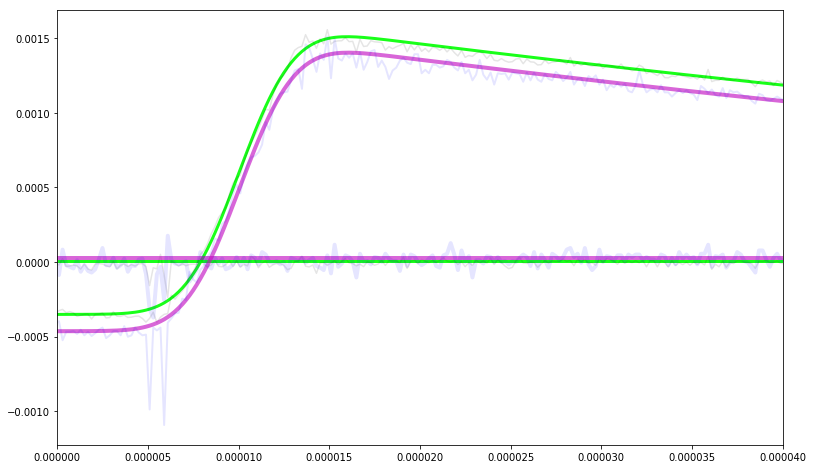

Xe-100_P-09_E-200
OPT high G =  [ 1.00070045e-05  2.39980670e-06  9.82782775e-04 -9.74331692e-04]
OPT high S =  [ 1.93929067e-04  6.60133963e-06 -4.42996315e-04  1.18723165e-05]
G chi =  0.781724695798272
A chi =  0.272704169393318
OPT low G =  [0.         0.         0.00171944 0.00171944]
OPT low S =  [ 0.00000000e+00  0.00000000e+00 -7.46184640e-04 -4.45502565e-05]
G chi =  nan
A chi =  nan


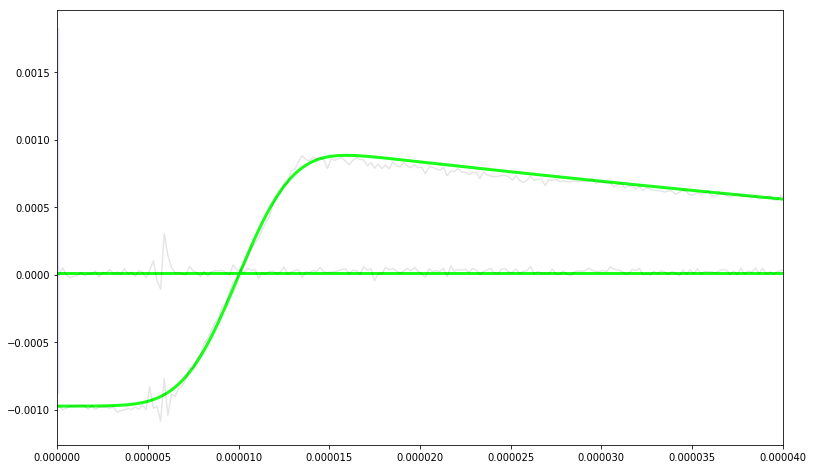

Xe-100_P-09_E-250
OPT high G =  [ 1.00036893e-05  2.43834036e-06  9.89072944e-04 -1.61976870e-03]
OPT high S =  [ 1.83407877e-04  6.02922905e-06 -5.02764002e-04  3.24465697e-06]
G chi =  0.6551519824484092
A chi =  0.1913369730996848
OPT low G =  [0.         0.         0.00233307 0.00233307]
OPT low S =  [ 0.00000000e+00  0.00000000e+00 -8.91925156e-04 -2.53031634e-05]
G chi =  nan
A chi =  nan


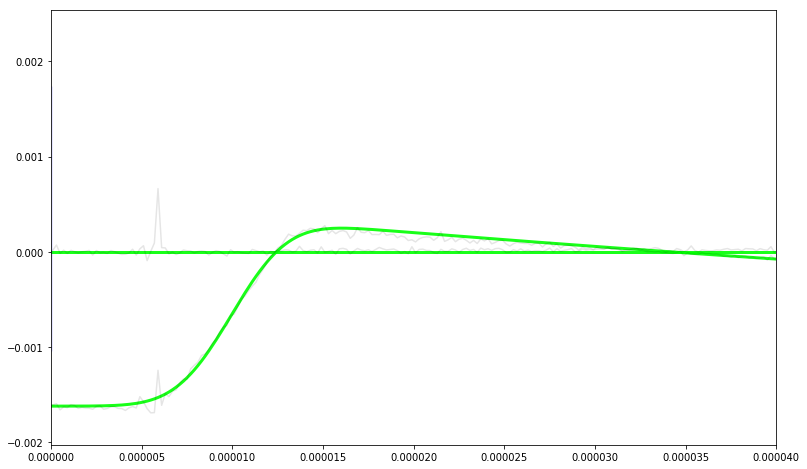

Xe-100_P-09_E-300
OPT high G =  [ 9.91493929e-06  2.24865855e-06  1.01006764e-03 -2.65923892e-03]
OPT high S =  [ 1.77344044e-04  6.12737561e-06 -5.84070551e-04  1.33695319e-05]
G chi =  1.4349932972471997
A chi =  0.34307933821871184


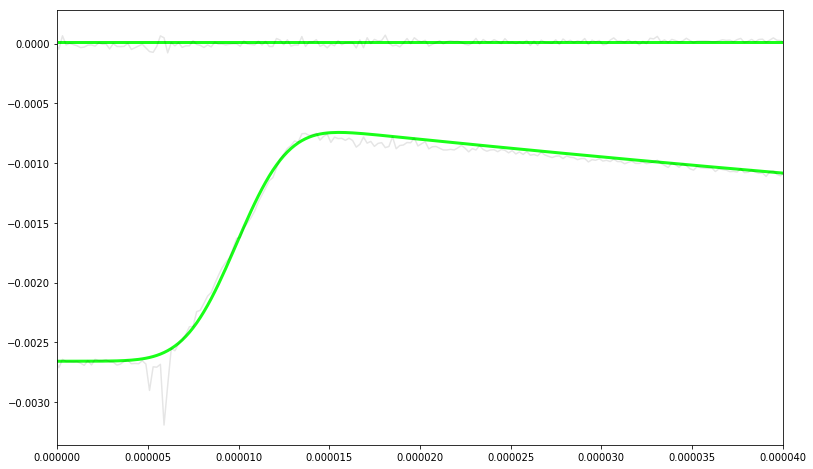

Xe-100_P-09_E-350
OPT high G =  [ 9.88341803e-06  2.45288493e-06  1.01271994e-03 -1.00821156e-02]
OPT high S =  [ 1.73386436e-04  5.98445071e-06 -6.46366234e-04  7.40126541e-06]
G chi =  1.2774051119884602
A chi =  0.5819884833308308


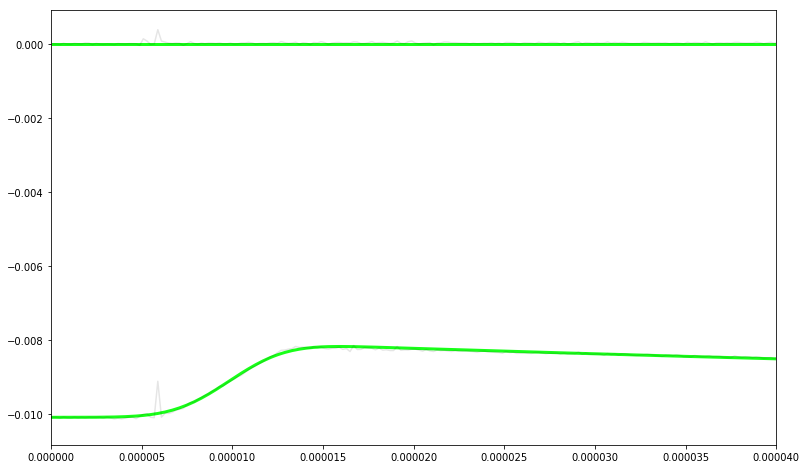

Xe-100_P-11_E-100
OPT high G =  [ 1.05954221e-05  2.64196187e-06  9.26026207e-04 -9.29521213e-05]
OPT high S =  [ 6.23981224e-04  2.18979858e-05 -9.83067662e-05 -5.35049499e-06]
G chi =  0.4529680833997629
A chi =  0.23443084382442916
OPT low G =  [ 1.06057963e-05  2.62436965e-06  9.23566935e-04 -1.25015874e-04]
OPT low S =  [ 6.21636530e-04  2.15693893e-05 -1.00968394e-04 -7.64256922e-06]
G chi =  0.9183664093962508
A chi =  0.5273863685851932


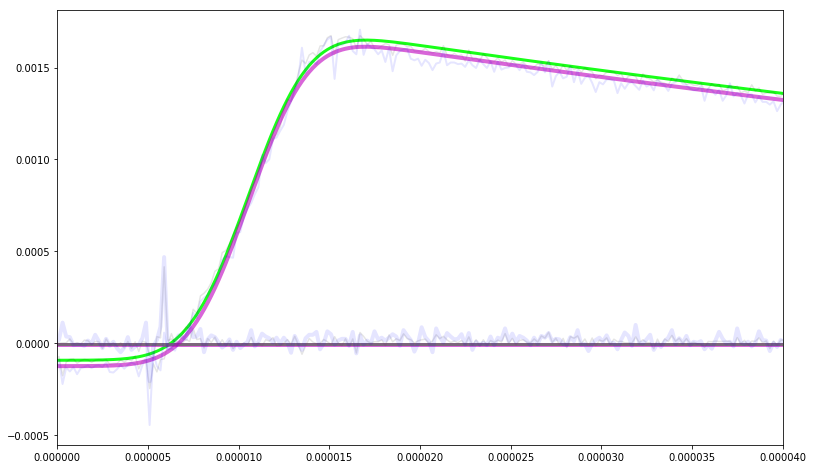

Xe-100_P-11_E-150
OPT high G =  [ 1.05400104e-05  2.56299898e-06  9.11469364e-04 -4.49291199e-04]
OPT high S =  [ 2.82431613e-04  9.58307688e-06 -3.01937466e-04  1.44449704e-05]
G chi =  0.5419221235267736
A chi =  0.19646227456903914
OPT low G =  [ 1.06031885e-05  2.57119678e-06  9.14974411e-04 -4.77096549e-04]
OPT low S =  [ 2.82307231e-04  9.63275589e-06 -3.06548059e-04  9.00925834e-06]
G chi =  1.1287922636883057
A chi =  1.1993805353715614


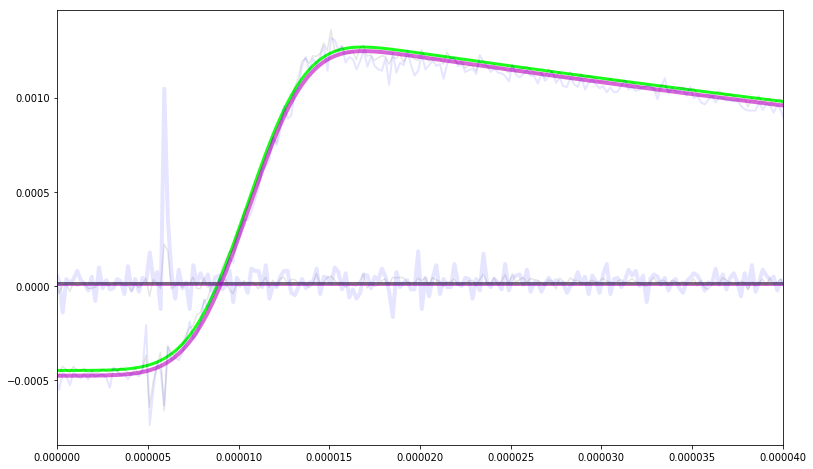

Xe-100_P-11_E-200
OPT high G =  [ 1.04281593e-05  2.58802156e-06  9.07012155e-04 -8.64909588e-04]
OPT high S =  [ 2.14577755e-04  6.89262764e-06 -3.98999549e-04 -2.13361531e-06]
G chi =  0.5184875862211502
A chi =  0.26267606940326954
OPT low G =  [0.         0.         0.00184738 0.00184738]
OPT low S =  [ 0.00000000e+00  0.00000000e+00 -7.27100454e-04 -3.50469655e-05]
G chi =  nan
A chi =  nan


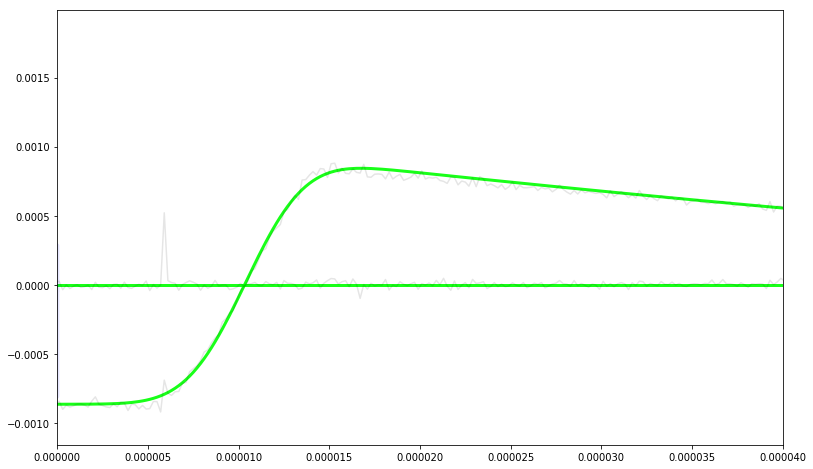

Xe-100_P-11_E-250
OPT high G =  [ 9.91317888e-06 -1.24677428e-06 -5.03044147e-04 -4.29723344e-04]
OPT high S =  [ 1.94831339e-04  6.53100652e-06 -4.87070083e-04  4.67483118e-06]
G chi =  26.569074738656603
A chi =  0.244870757171677


TypeError: Improper input: N=4 must not exceed M=0

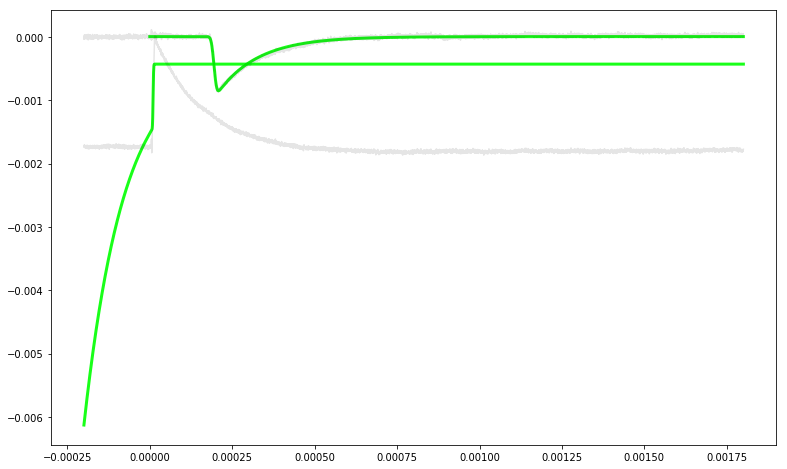

In [7]:
ChG = []
ChS = []
#for per in range(0,len(FOLD)):
for per in [0]:

    #SPATH = '/Users/austinmcdonald/Desktop/XeAr/Data/'+FOLD[per]
    PATH = '/Users/austinmcdonald/Desktop/XeAr/'+FOLD[per]
    folders = glob.glob(PATH+"*/")
    folders.sort()
    
    
    for F in range(0,len(folders)):
    #for F in [5]:
        NAME = folders[F].split('/')[-2]
        print(NAME)
        files = os.listdir(folders[F])
        if '.DS_Store' in files: files.remove('.DS_Store')
        CHI = 1000000
        FG,FS = FILE_SORTER(files)
        Mx,MEAN = MEAN_WAVEFORM(folders[F],FG)
        Gx,Gy,ChiG = WAVEFORM_QUALITY(folders[F],FG,MEAN,CHI)
        

        Mx,MEAN = MEAN_WAVEFORM(folders[F],FS)
        Sx,Sy,ChiS = WAVEFORM_QUALITY(folders[F],FS,MEAN,CHI)
        
        ChG.append(ChiG)
        ChS.append(ChiS)
        
        TriggerTime  = find_nearest(Sx,0)
        Trigger      = np.where(Sx==TriggerTime)[0][0]
        baselineS    = np.mean(Sy[0:Trigger])
        baselineG    = np.mean(Sy[0:Trigger])
        XVALS  = Gx
        YVALSG = Gy-baselineG
        YVALSS = Sy-baselineS
        plt.figure(figsize=(13,8))

        if np.mean(np.nan_to_num(YVALSG))!=0 and np.mean(np.nan_to_num(YVALSS))!=0:
            xa,ya,opta,chia = FITTER_ANOD(XVALS,YVALSS)
            xg,yg,optg,chig = FITTER_GOLD(XVALS,YVALSG)
            plt.plot(xa,funcA(xa,*opta),color='lime',alpha=0.9,linewidth=3)
            plt.plot(xg,funcG(xg,*optg),color='lime',alpha=0.9,linewidth=3)
            print("OPT high G = ",optg)
            print("OPT high S = ",opta)
            print("G chi = ",chig*1e6)
            print("A chi = ",chia*1e6)
        #print("Chi Gold = ",ChiG)
        #print("Chi Anod = ",ChiS)

        plt.plot(XVALS,YVALSG,color='k',alpha=0.1)
        plt.plot(XVALS,YVALSS,color='k',alpha=0.1)
        
        
        CHI = 0.7

        Mx,MEAN = MEAN_WAVEFORM(folders[F],FG)
        Gx,Gy,ChiG = WAVEFORM_QUALITY(folders[F],FG,MEAN,CHI)
        

        Mx,MEAN = MEAN_WAVEFORM(folders[F],FS)
        Sx,Sy,ChiS = WAVEFORM_QUALITY(folders[F],FS,MEAN,CHI)
        
        ChG.append(ChiG)
        ChS.append(ChiS)
        
        TriggerTime  = find_nearest(Sx,0)
        Trigger      = np.where(Sx==TriggerTime)[0][0]
        baselineS    = np.mean(Sy[0:Trigger])
        baselineG    = np.mean(Sy[0:Trigger])
        XVALS  = Gx
        YVALSG = Gy-baselineG
        YVALSS = Sy-baselineS
        if np.mean(np.nan_to_num(YVALSG))!=0 and np.mean(np.nan_to_num(YVALSS))!=0:
            xa,ya,opta,chia = FITTER_ANOD(XVALS,YVALSS)
            xg,yg,optg,chig = FITTER_GOLD(XVALS,YVALSG)
            plt.plot(xa,funcA(xa,*opta),color='m',alpha=0.6,linewidth=4)
            plt.plot(xg,funcG(xg,*optg),color='m',alpha=0.6,linewidth=4)
            print("OPT low G = ",optg)
            print("OPT low S = ",opta)
            print("G chi = ",chig*1e6)
            print("A chi = ",chia*1e6)
            
            
        plt.plot(XVALS,YVALSG,color='b',alpha=0.1,linewidth=2)
        plt.plot(XVALS,YVALSS,color='b',alpha=0.1,linewidth=4)
        
        plt.xlim(0,0.0010)
        plt.xlim(0,0.00070)
        plt.xlim(0,.000040)
        #plt.ylim(-0.001,0.001)
        plt.show()
        
        
        
        #data = [Gx, Gy-baselineG, Sy-baselineS]
        #np.savetxt(SPATH+NAME+'.txt',data)

In [100]:
def FITTER_GOLD(x,y):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)

    #xx = moving_average(XX,20)
    #yy = moving_average(YY,20)
    xx = moving_average(XX,5)
    yy = moving_average(YY,5)

    xxx = xx[Trigger:]
    yyy = yy[Trigger:]

    miny = max(yyy)

    hold      = find_nearest(yyy,miny)
    MINLOC     = np.where(yyy==hold)[0][0]

    TT = Trigger+MINLOC
    TT = int(TT)

    xxxx = xx[Trigger:TT]
    yyyy = yy[Trigger:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = Trigger+REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 1000
    cut2=cut-100
    fitX = XX[Arr-500:Arr+cut]#XX[Arr-cut2:Arr+cut]
    fitY = YY[Arr-500:Arr+cut]#YY[Arr-cut2:Arr+cut]

    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=fitval)

    chi = sum((funcG(fitX,*optim)- fitY)**2)
    return fitX,fitY,optim,chi

Xe-100_P-01_E-080
Sigma =  1.6264388043718061e-06
G chi =  49.02578208315233


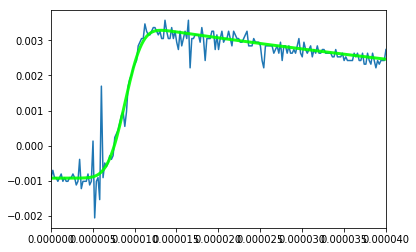

Sigma =  1.8988319634447536e-06
G chi =  45.6527178268817


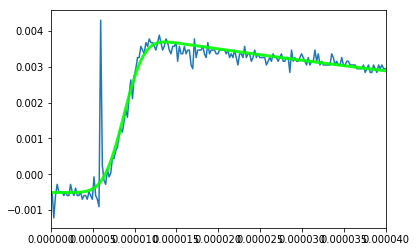

Sigma =  1.524167936527288e-06
G chi =  38.80314056040244


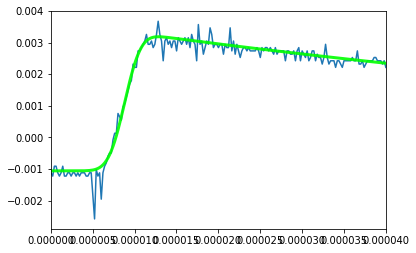

Sigma =  1.6348788411592153e-06
G chi =  27.971366775238145


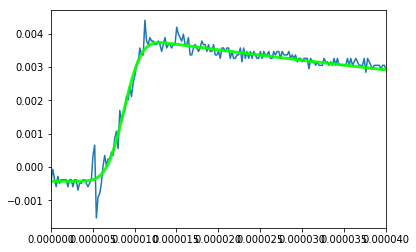

Sigma =  1.5301790738512567e-06
G chi =  43.155907409005046


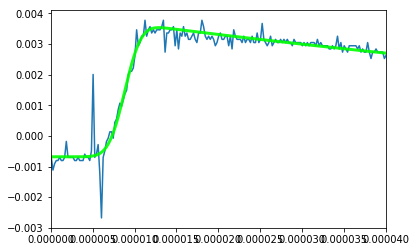

Sigma =  1.771587631686559e-06
G chi =  57.12587716157534


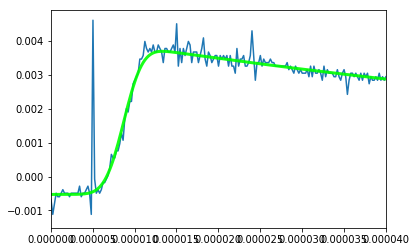

Sigma =  1.6368636532695684e-06
G chi =  34.87389427200654


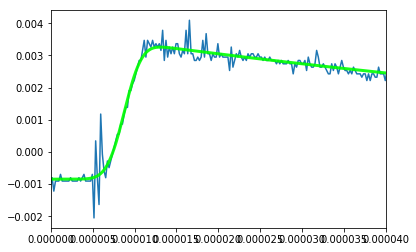

Sigma =  1.925385025774127e-06
G chi =  40.6193338343536


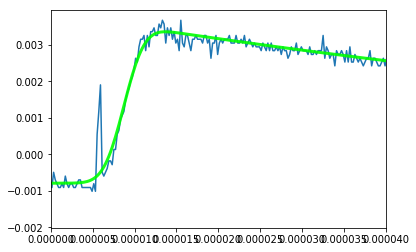

Sigma =  1.4726092550626678e-06
G chi =  38.9799018860066


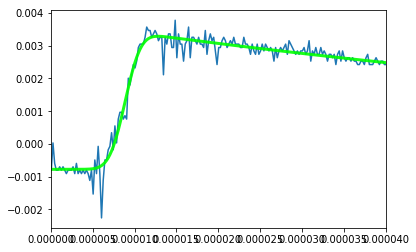

Sigma =  1.6437324858626946e-06
G chi =  29.37784723226219


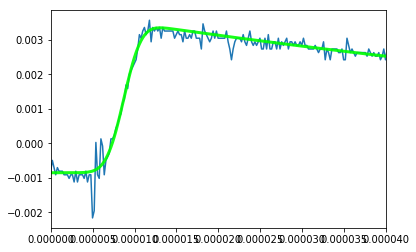

Sigma =  1.6646694742643886e-06
G chi =  36.99765610225583


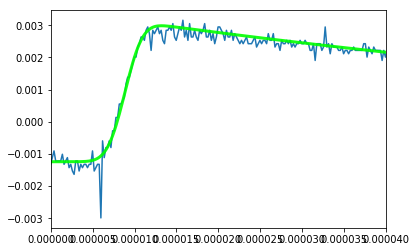

Sigma =  1.9765172730151262e-06
G chi =  70.85008757831154


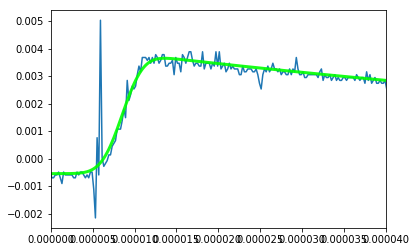

Sigma =  1.5934398471212133e-06
G chi =  37.51500056529649


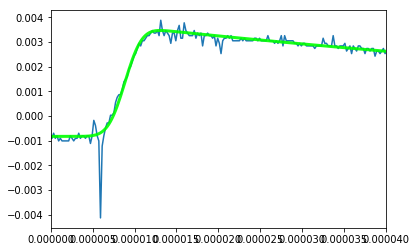

Sigma =  1.697819713197324e-06
G chi =  38.20128133258458


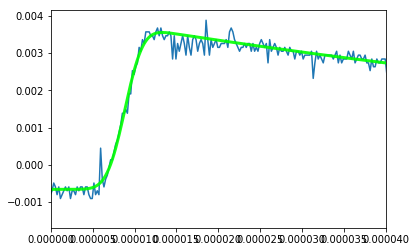

Sigma =  1.8327147300384717e-06
G chi =  26.15098994354381


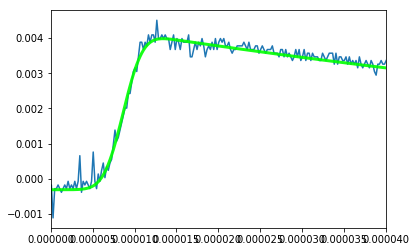

Sigma =  1.669686043879782e-06
G chi =  39.38307163870594


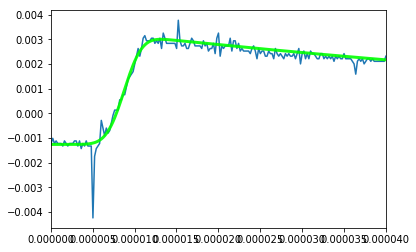

Sigma =  1.6717290117691367e-06
G chi =  39.199621007183616


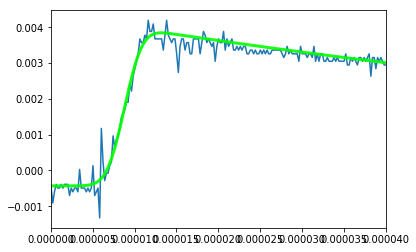

Sigma =  1.5381473804447421e-06
G chi =  42.17847990880435


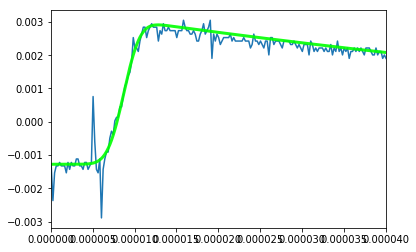

Sigma =  2.072533681694236e-06
G chi =  36.79777686052793


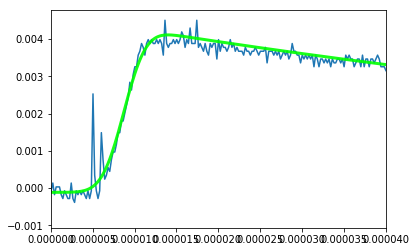

Sigma =  1.7113070676140306e-06
G chi =  42.52378340776119


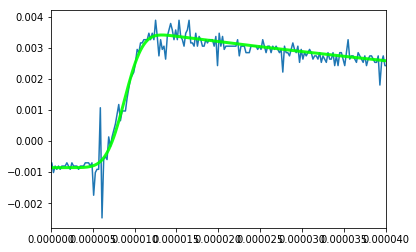

Sigma =  2.2323955586849504e-06
G chi =  76.16964114849095


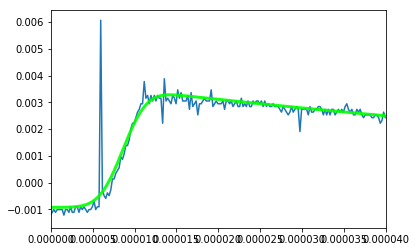

Sigma =  1.6448431424721327e-06
G chi =  37.229244321402724


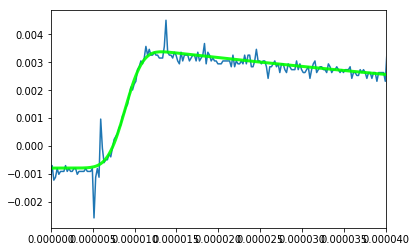

Sigma =  1.454259497798718e-06
G chi =  39.617340083492536


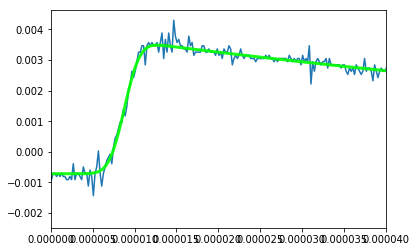

Sigma =  1.5473249959432357e-06
G chi =  31.158282377358702


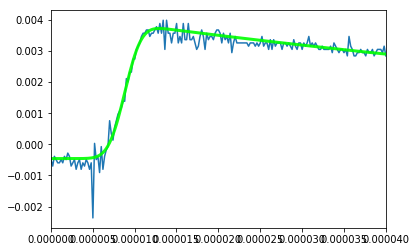

Sigma =  1.7497385180786514e-06
G chi =  39.42754144150776


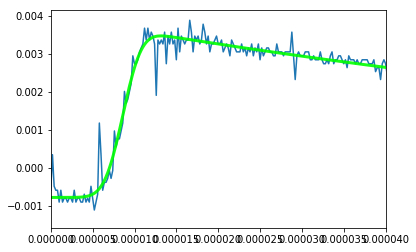

Sigma =  1.5053654076308748e-06
G chi =  38.33280083431842


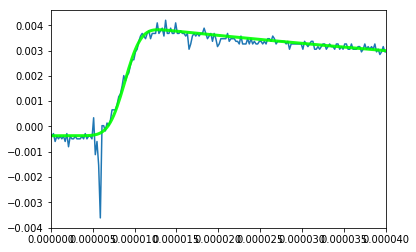

Sigma =  1.6788718127349141e-06
G chi =  39.51783233953847


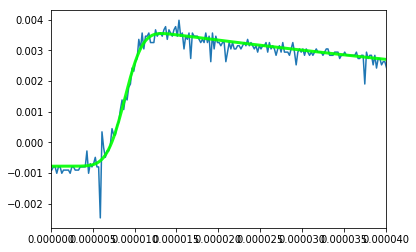

Sigma =  1.8275600074438054e-06
G chi =  39.59750644682643


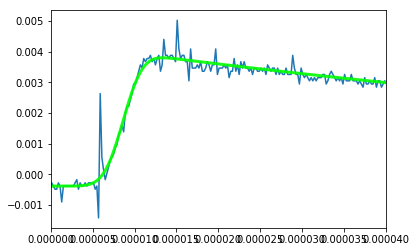

Sigma =  1.3544713234691647e-06
G chi =  100.8948347677747


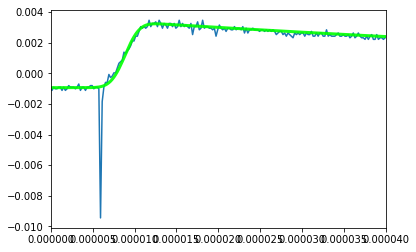

Sigma =  1.4830343007737372e-06
G chi =  44.68108941684106


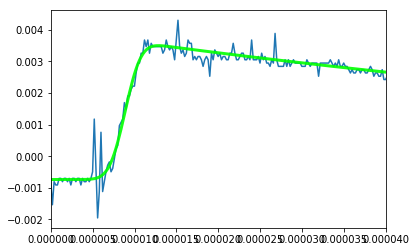

Sigma =  1.6619986845937566e-06
G chi =  35.47442372495249


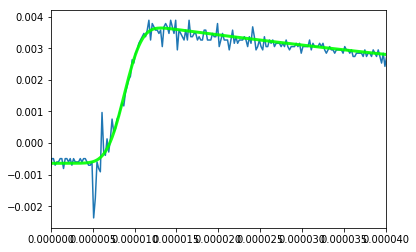

Sigma =  1.7390455886549322e-06
G chi =  35.04250670978472


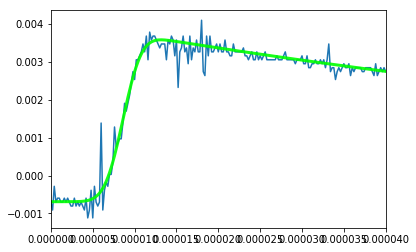

Sigma =  1.754427656918029e-06
G chi =  39.04328614376525


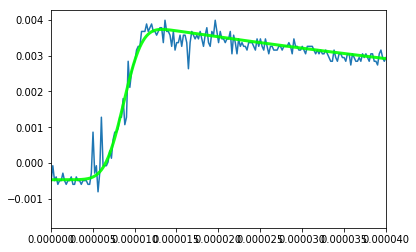

Sigma =  1.5826077332343737e-06
G chi =  29.362313615121618


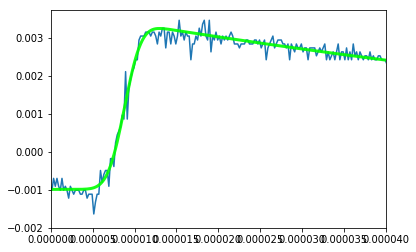

Sigma =  1.6880248686609588e-06
G chi =  35.21709453707933


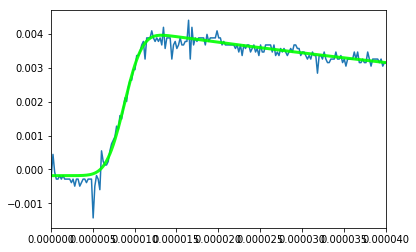

Sigma =  1.8090916250898683e-06
G chi =  54.01180337435977


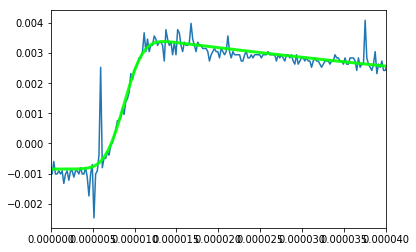

Sigma =  2.087378240315868e-06
G chi =  45.564587894225326


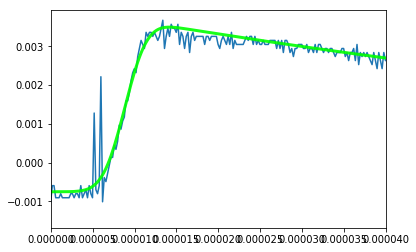

Sigma =  1.726885827012792e-06
G chi =  37.808591992253106


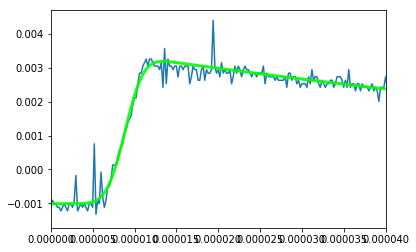

Sigma =  1.6554050191393534e-06
G chi =  39.80255823997957


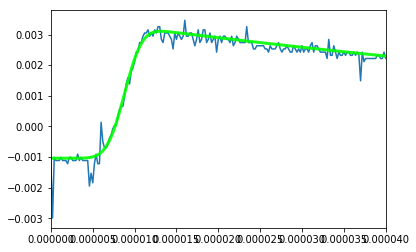

Sigma =  1.6486764940859438e-06
G chi =  31.702903974082243


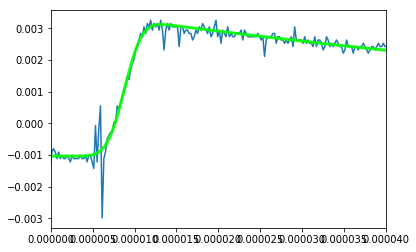

Sigma =  1.6740693937492358e-06
G chi =  36.71153767066863


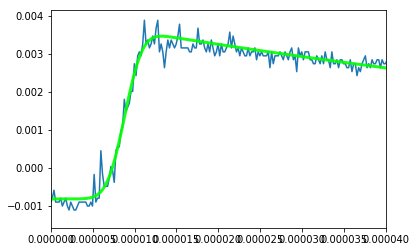

Sigma =  1.5851332509255544e-06
G chi =  36.2067052320542


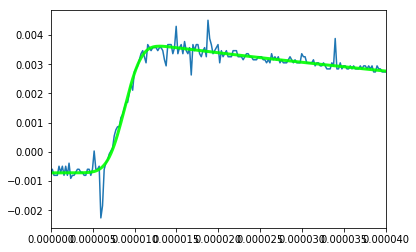

Sigma =  1.7475630617030125e-06
G chi =  25.369102652891254


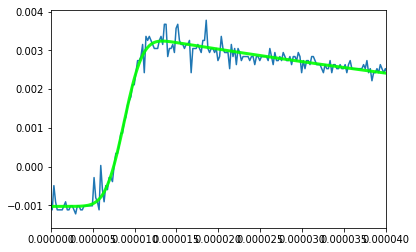

Sigma =  1.5985182219382495e-06
G chi =  42.69665789913053


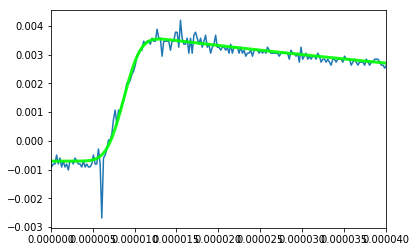

Sigma =  1.4971356081197078e-06
G chi =  39.25348064787771


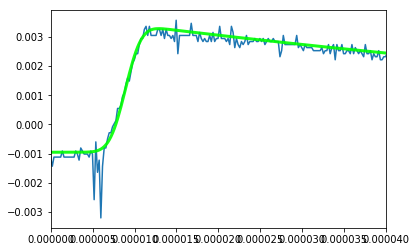

Sigma =  1.4795639733485357e-06
G chi =  48.55299992310101


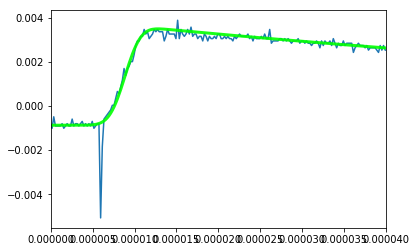

Sigma =  1.5370196219196463e-06
G chi =  44.32467636587305


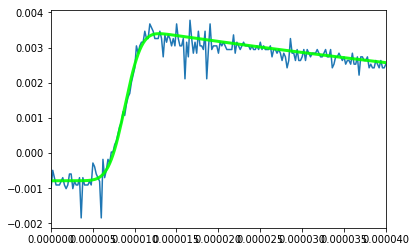

Sigma =  1.6401167821966453e-06
G chi =  27.052898702691206


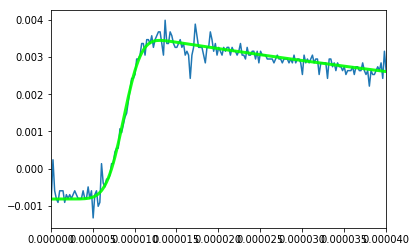

Sigma =  1.765229505072189e-06
G chi =  32.15423957313055


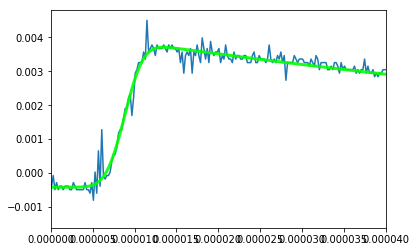

Sigma =  1.4994631232682242e-06
G chi =  34.32897653691401


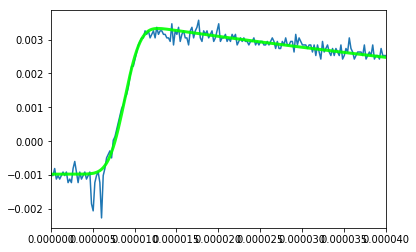

Sigma =  1.6693745152981472e-06
G chi =  41.82769421377749


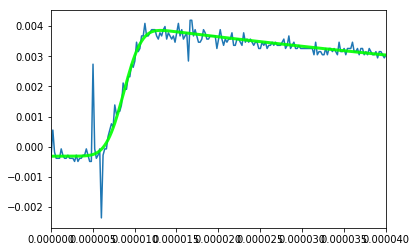

Sigma =  1.4332547185963779e-06
G chi =  108.3457698718948


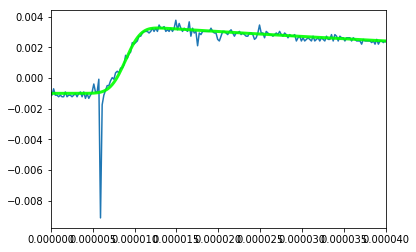

Sigma =  1.659640338745607e-06
G chi =  42.21697028012321


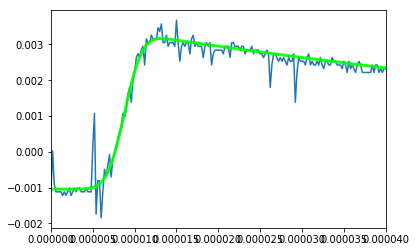

Sigma =  1.8524662044680207e-06
G chi =  38.720465773079496


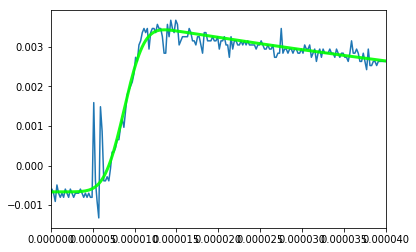

Sigma =  1.5437138356395557e-06
G chi =  36.85023206208483


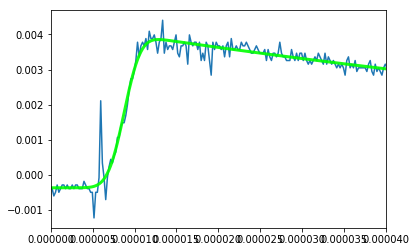

Sigma =  1.5458809790400812e-06
G chi =  36.20355774862936


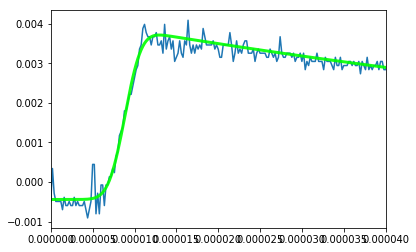

Sigma =  1.4528904882679262e-06
G chi =  29.43802272732391


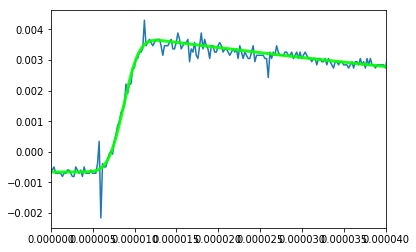

Sigma =  2.0702143591988247e-06
G chi =  50.71979225468034


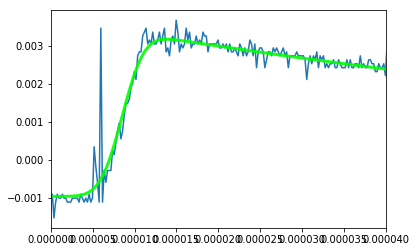

Sigma =  1.772626022374478e-06
G chi =  30.511217680383066


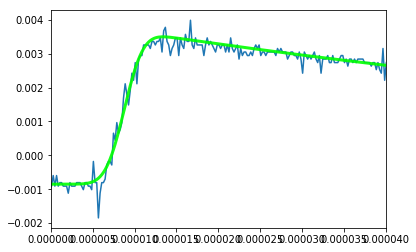

Sigma =  1.5084972855933227e-06
G chi =  41.41473948197092


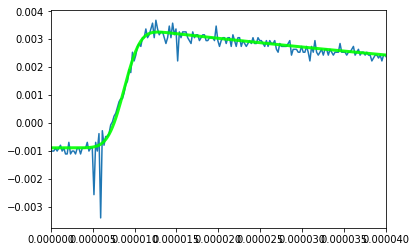

Sigma =  1.8222691363349727e-06
G chi =  39.31912934047692


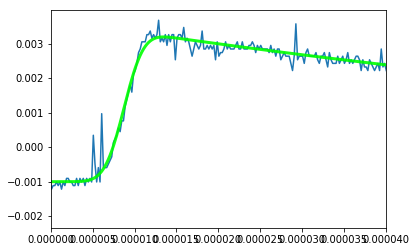

Sigma =  1.4893293108674484e-06
G chi =  29.12458438153641


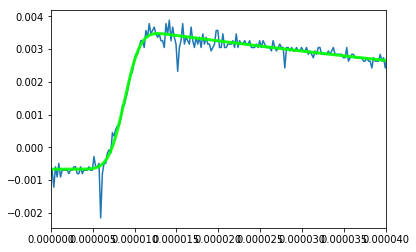

Sigma =  1.5378808517068914e-06
G chi =  39.549706985692005


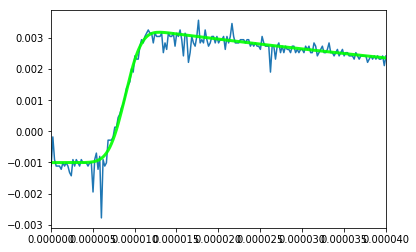

Sigma =  1.4993969398530268e-06
G chi =  34.980983937795024


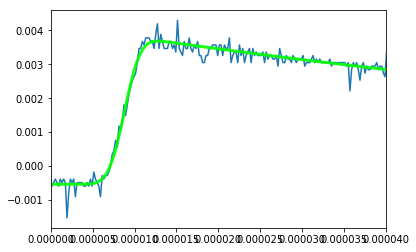

Sigma =  1.5373215765323064e-06
G chi =  40.6477323672834


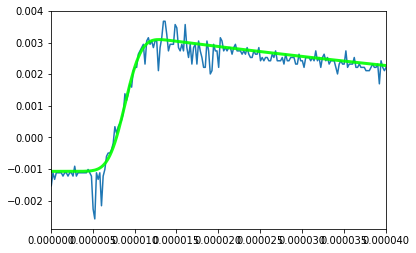

Sigma =  2.56180232252618e-06
G chi =  67.40872229152758


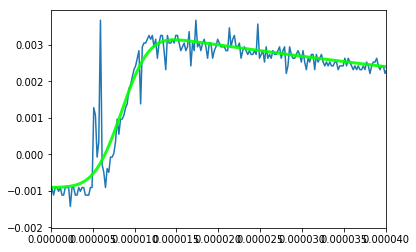

Sigma =  1.6812835904916203e-06
G chi =  49.67739978310284


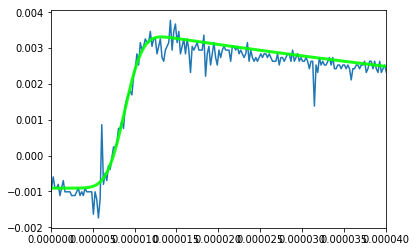

Sigma =  1.539630986027541e-06
G chi =  35.233683103238704


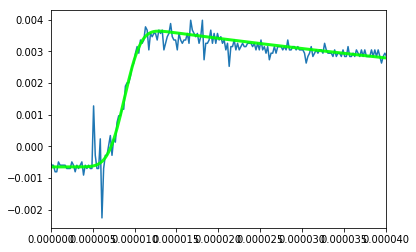

Sigma =  1.5881283521713463e-06
G chi =  44.19929961296253


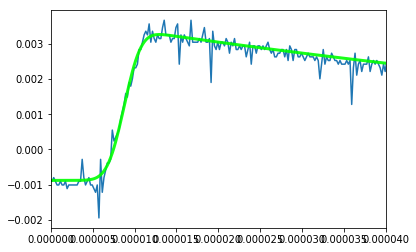

Sigma =  1.6273702512451869e-06
G chi =  32.52790439124073


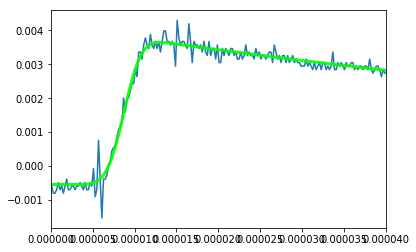

Sigma =  1.5864124549904124e-06
G chi =  32.92983863978849


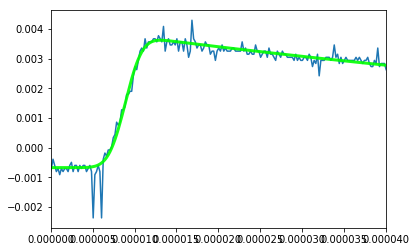

Sigma =  1.6849767894422557e-06
G chi =  39.34813946850542


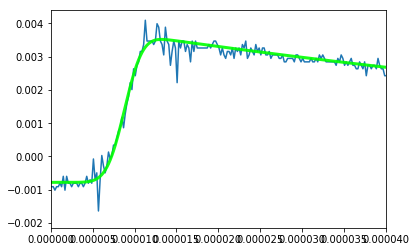

Sigma =  1.6153389295517535e-06
G chi =  28.176338094141123


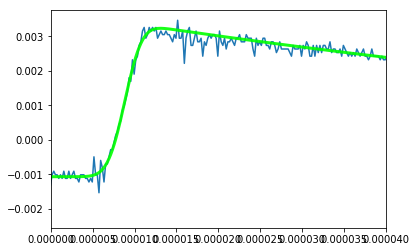

Sigma =  1.5378317071084296e-06
G chi =  33.49036397151244


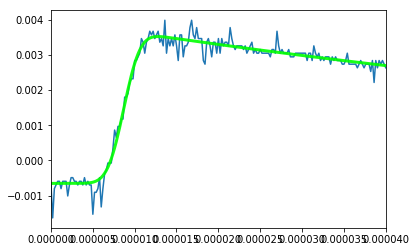

Sigma =  1.7182278754670556e-06
G chi =  43.437139304295286


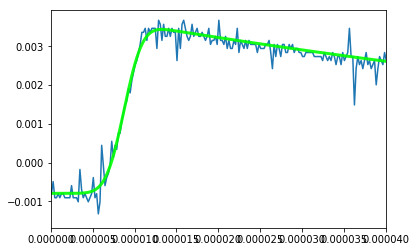

Sigma =  1.7261351085028019e-06
G chi =  37.4019142280564


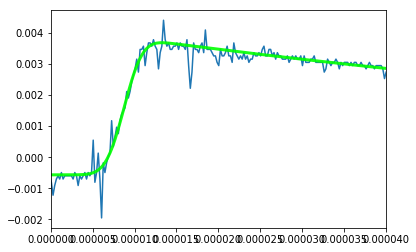

Sigma =  1.4442696706908176e-06
G chi =  72.39713666825911


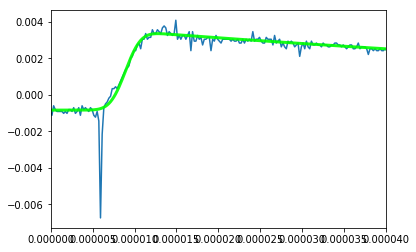

Sigma =  1.974815259547602e-06
G chi =  40.93194725811816


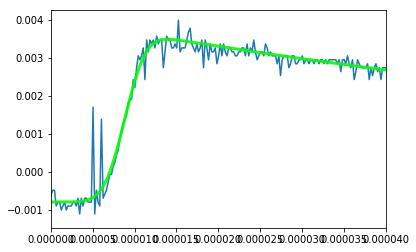

Sigma =  1.4267979415952813e-06
G chi =  31.758351393052983


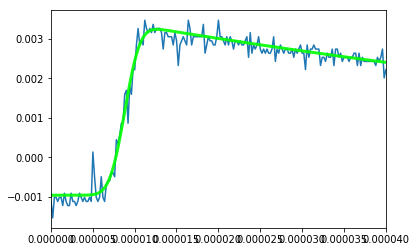

Sigma =  1.5666301449200502e-06
G chi =  61.92057498456719


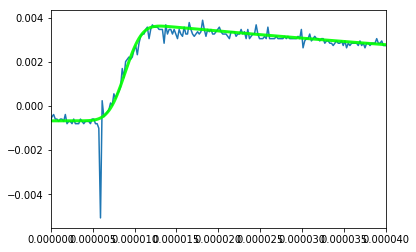

Sigma =  1.4579647249407061e-06
G chi =  49.565362048565724


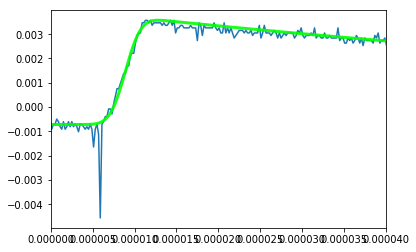

Sigma =  1.5826124955103168e-06
G chi =  27.87104772661648


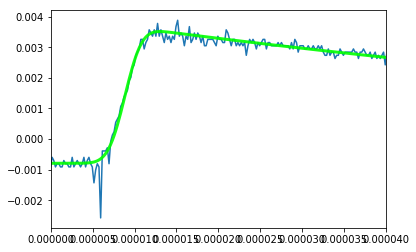

Sigma =  1.6657052583484065e-06
G chi =  44.564755570214125


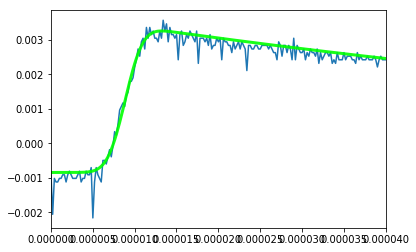

Sigma =  1.5064229715121135e-06
G chi =  38.7316030397045


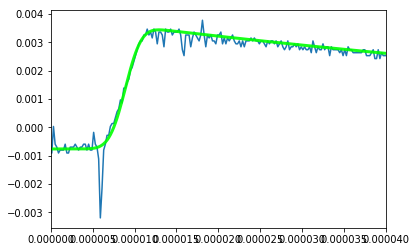

Sigma =  1.6056589427531839e-06
G chi =  49.1172080687524


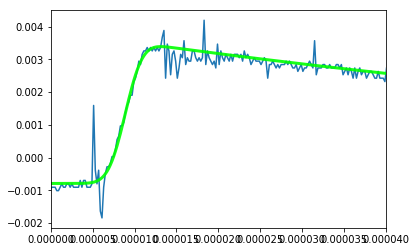

Sigma =  1.6343244835906017e-06
G chi =  40.24216556201969


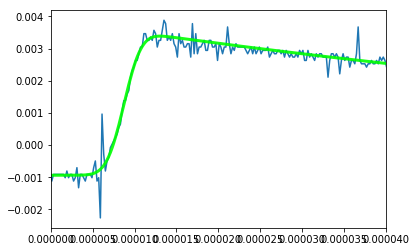

Sigma =  1.5492943202373872e-06
G chi =  36.64782735009767


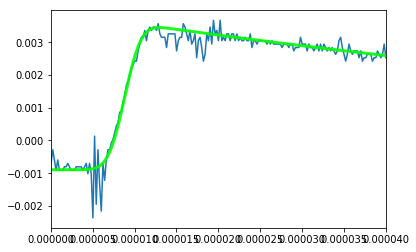

Sigma =  1.8022245765989453e-06
G chi =  51.30095186883725


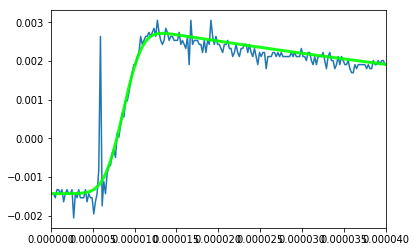

Sigma =  1.7135199780572804e-06
G chi =  48.29393795764291


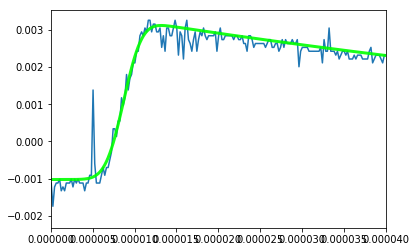

Sigma =  1.5109197704798106e-06
G chi =  27.77121942046708


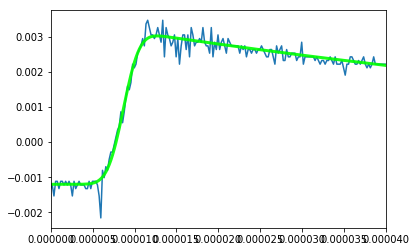

Sigma =  2.2856574794652803e-06
G chi =  62.706028243115995


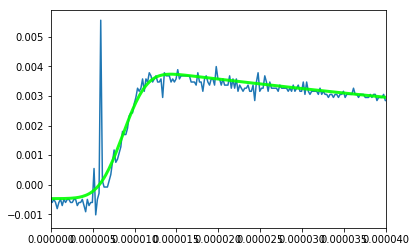

Sigma =  2.1216239321793903e-06
G chi =  72.37111485245966


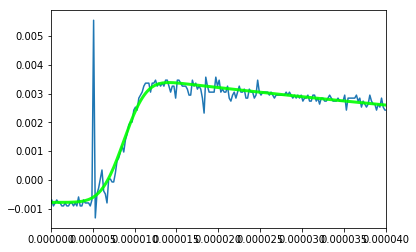

Sigma =  1.7353522860240785e-06
G chi =  62.43789766389617


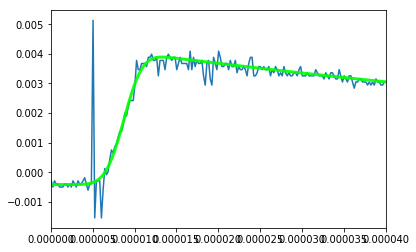

Sigma =  1.3473581401783695e-06
G chi =  108.65592874339221


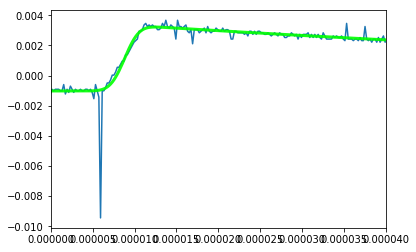

Sigma =  1.670834040883414e-06
G chi =  44.51536128064847


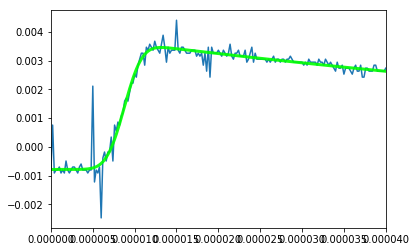

Sigma =  1.5198440221940468e-06
G chi =  30.60723450853006


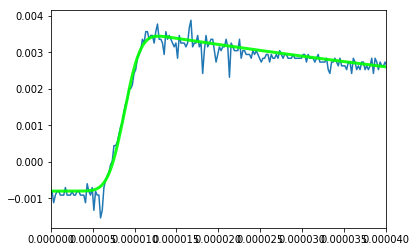

Sigma =  1.5418545946093352e-06
G chi =  50.395486739976384


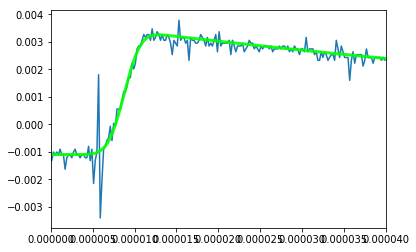

Sigma =  1.481652601169323e-06
G chi =  41.007958744746105


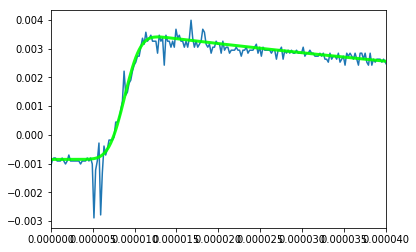

Sigma =  1.766746368383112e-06
G chi =  36.274325738433944


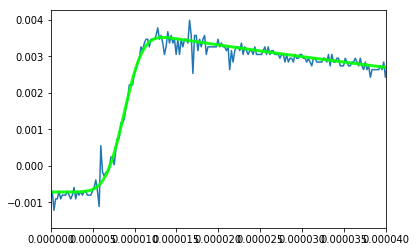

In [157]:
ChG = []
ChS = []
#for per in range(0,len(FOLD)):
for per in [0]:

    #SPATH = '/Users/austinmcdonald/Desktop/XeAr/Data/'+FOLD[per]
    PATH = '/Users/austinmcdonald/Desktop/XeAr/'+FOLD[per]
    folders = glob.glob(PATH+"*/")
    folders.sort()
    
    
    #for F in range(0,len(folders)):
    for F in [0]:
        NAME = folders[F].split('/')[-2]
        print(NAME)
        files = os.listdir(folders[F])
        if '.DS_Store' in files: files.remove('.DS_Store')
        FG,FS = FILE_SORTER(files)
        Yvals = np.zeros(10002)
        Xvals = np.zeros(10002)
        avg = 0
        SIG = []
        CH  =[]
        Clim = 100
        Mx,MEAN = MEAN_WAVEFORM(folders[F],FG)
        xs,ys,OPT,chis = FITTER_GOLD(Mx,MEAN)
        for w in range(0,len(FG)):
        #for w in range(0,20):
        #for w in [0]:
            
            X, Y, info = readTrc(folders[F]+FG[w])
            if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
                #plt.plot(X,Y)
                xg,yg,optg,chig = FITTER_GOLD(X,Y)
                #print("OPT high G = ",optg)
                print("Sigma = ",optg[1])
                if chig*1e6 <Clim and optg[1]>0:
                    SIG.append(optg[1])
                print("G chi = ",chig*1e6)
                CH.append(chig*1e6)
                plt.plot(xg,yg)
                plt.plot(xg,funcG(xg,*optg),color='lime',alpha=0.9,linewidth=3)
                plt.xlim(0,.000040)
                plt.show()


In [123]:
SIG = np.array(SIG)*1e6
CH = np.array(CH)

In [124]:
np.mean(SIG)**2

2.8121666299872285

In [125]:
np.std(SIG)

0.19520824209834117

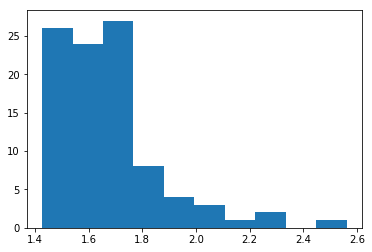

In [126]:
plt.hist(SIG,bins=10)
plt.show()

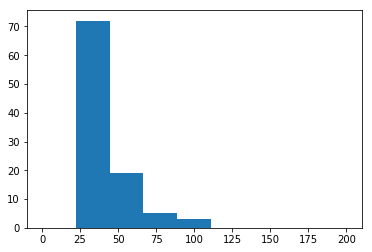

In [127]:
plt.hist(CH,bins=np.linspace(0,200,10))
plt.show()

In [156]:
(OPT[0]*1e6)

8.80026818961846

In [149]:
def FITTER_ANOD(x,y):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)
    XX = XX[Trigger:]
    YY = YY[Trigger:]

    xx = moving_average(XX,10)
    yy = moving_average(YY,10)

    xxx = xx[Trigger:]
    yyy = yy[Trigger:]

    miny = min(yy)

    hold      = find_nearest(yy,miny)
    MINLOC     = np.where(yy==hold)[0][0]

    TT = MINLOC
    TT = int(TT)

    xxxx = xx[:TT]
    yyyy = yy[:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 400
    cut2=cut-50
    if XX[Arr-cut2:Arr+cut].shape[0]!=0:
        fitX = XX[Arr-cut2:Arr+cut]
        fitY = YY[Arr-cut2:Arr+cut]
    else:
        fitX = XX[0:Arr+cut]
        fitY = YY[0:Arr+cut]


    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=fitval)

    chi = sum((funcA(fitX,*optim)- fitY)**2)
    return xx,yy,optim,chi

def FITTER_ANOD2(x,y,PP):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)
    XX = XX[Trigger:]
    YY = YY[Trigger:]

    xx = moving_average(XX,10)
    yy = moving_average(YY,10)

    xxx = xx[Trigger:]
    yyy = yy[Trigger:]

    miny = min(yy)

    hold      = find_nearest(yy,miny)
    MINLOC     = np.where(yy==hold)[0][0]

    TT = MINLOC
    TT = int(TT)

    xxxx = xx[:TT]
    yyyy = yy[:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 400
    cut2=cut-50
    if XX[Arr-cut2:Arr+cut].shape[0]!=0:
        fitX = XX[Arr-cut2:Arr+cut]
        fitY = YY[Arr-cut2:Arr+cut]
    else:
        fitX = XX[0:Arr+cut]
        fitY = YY[0:Arr+cut]


    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=PP)

    chi = sum((funcA(fitX,*optim)- fitY)**2)
    return xx,yy,optim,chi

Xe-100_P-01_E-100


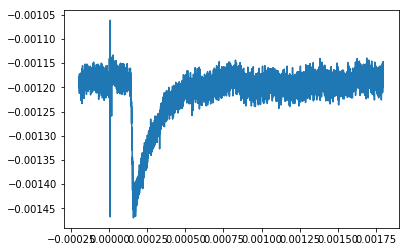

Sigma =  6.109013675267662e-05
A chi =  18.927828146051606


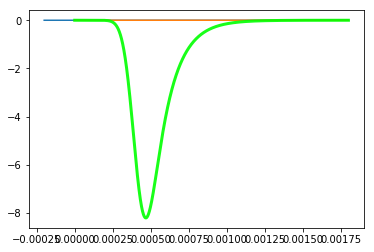

/Users/austinmcdonald/miniconda/envs/IC-3.6-2018-11-14/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in multiply


Sigma =  -4.0244367511699746e-05
A chi =  14.622985627187262


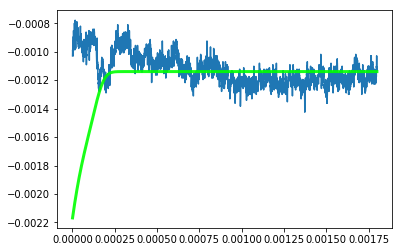

Sigma =  4.2114932208684356e-06
A chi =  12.864443218487446


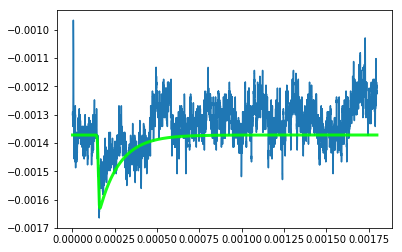

Sigma =  -3.1742294327570856e-05
A chi =  21.329581300400168


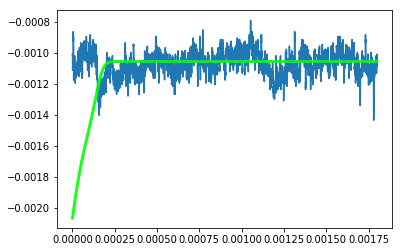

Sigma =  1.0596343044800221e-05
A chi =  14.06921002064561


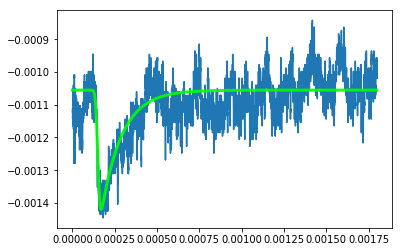

Sigma =  1.2632918972722606e-05
A chi =  13.314097291879127


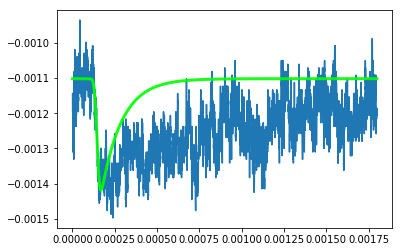

Sigma =  7.649159779686849e-06
A chi =  19.772516817794916


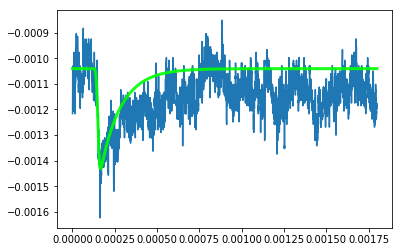

Sigma =  5.318731364881935e-06
A chi =  13.918507013042541


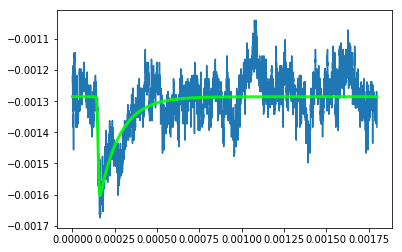

Sigma =  7.155440927103782e-06
A chi =  15.717539833725636


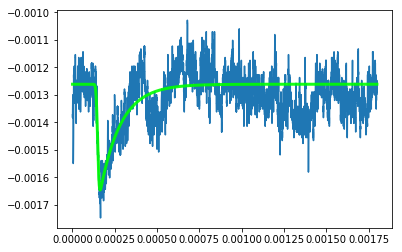

Sigma =  5.4285734049096444e-06
A chi =  75.20010628814957


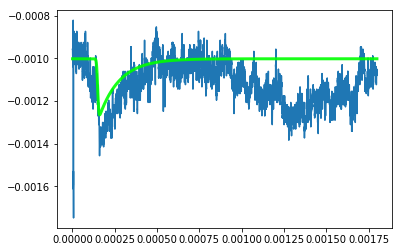

Sigma =  7.184684677766683e-06
A chi =  12.015383864211056


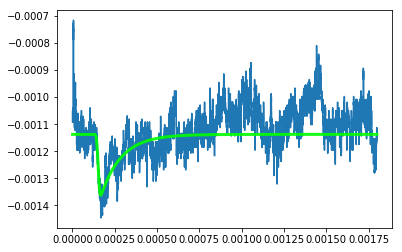

Sigma =  0.0009229567065534975
A chi =  19.712393282103466


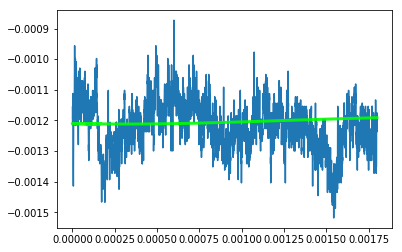

Sigma =  6.683670962995316e-06
A chi =  17.790732101355818


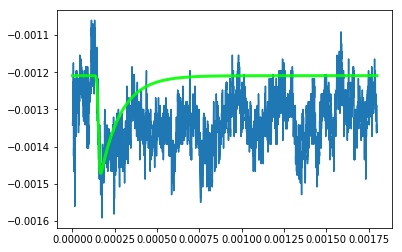

Sigma =  4.0869766852164474e-06
A chi =  14.322764656726465


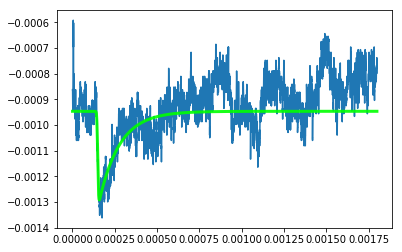

Sigma =  5.4285734049096444e-06
A chi =  19.585941302945646


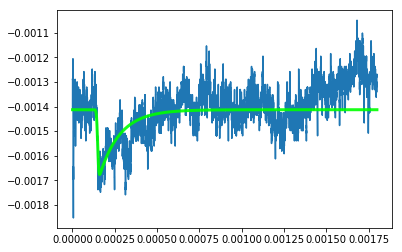

Sigma =  5.4285734049096444e-06
A chi =  23.335808854712766


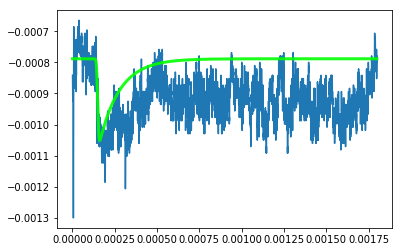

Sigma =  9.124189863925181e-06
A chi =  13.235344961357251


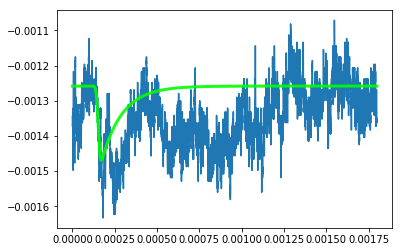

Sigma =  3.891924205332808e-06
A chi =  21.711289689523422


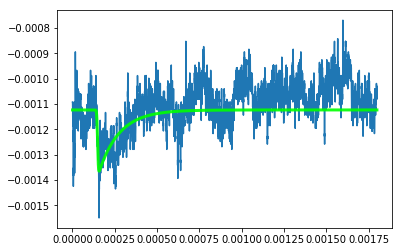

Sigma =  6.898329055338534e-06
A chi =  14.524820235372376


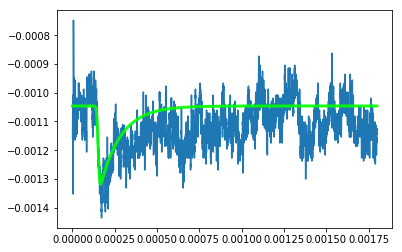

Sigma =  5.014114645625341e-06
A chi =  12.888117792698349


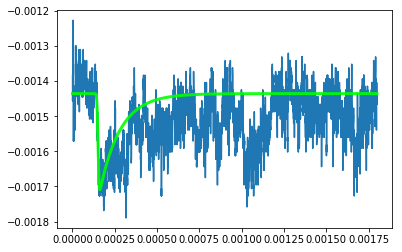

Sigma =  2.5412564394616746e-05
A chi =  17.18123805311509


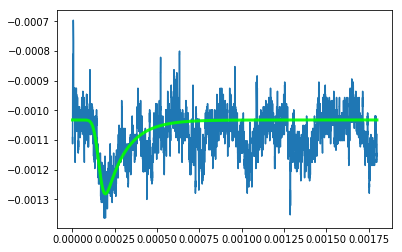

Sigma =  5.57441210896279e-06
A chi =  14.046473184587795


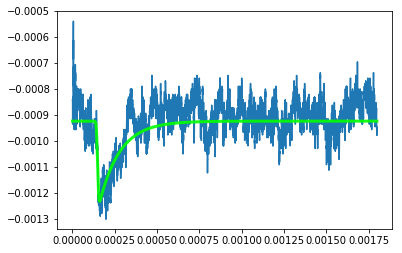

Sigma =  1.103728977265785e-05
A chi =  16.242769762307088


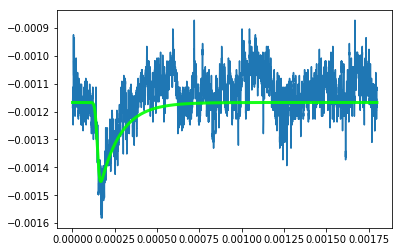

Sigma =  6.751847673740509e-05
A chi =  13.764268884214367


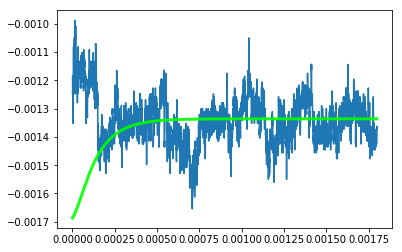

Sigma =  0.00043871460360328166
A chi =  16.485726961814148


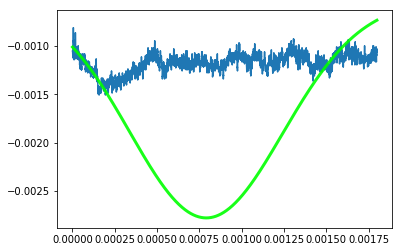

Sigma =  5.4285734049096444e-06
A chi =  19.431568054140158


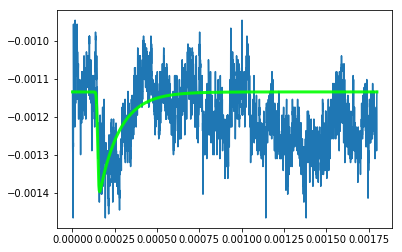

Sigma =  4.414904277133422e-07
A chi =  13.015781863426762


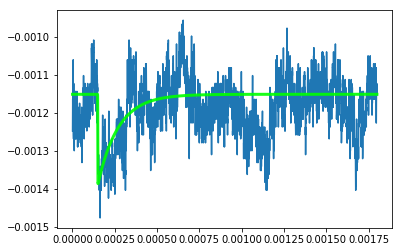

Sigma =  5.4285734049096444e-06
A chi =  30.784051304900544


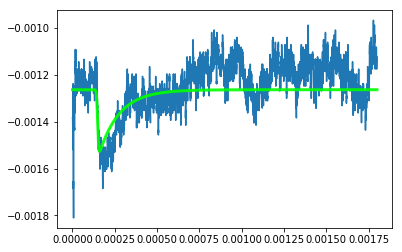

Sigma =  1.4035509298557114e-05
A chi =  16.904043030184265


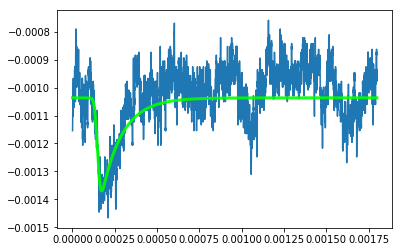

Sigma =  5.4285734049096444e-06
A chi =  19.30325116523678


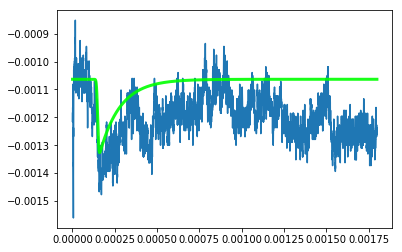

Sigma =  -8.634291149815279e-05
A chi =  17.160007610666494


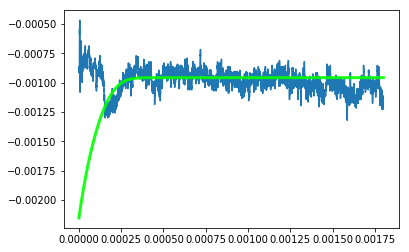

Sigma =  4.107164710648065e-06
A chi =  18.171622828395392


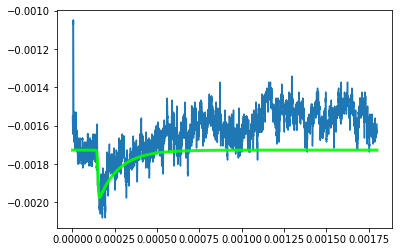

Sigma =  5.4285734049096444e-06
A chi =  26.289815719986382


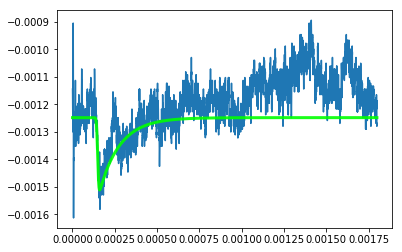

Sigma =  8.16131199291439e-06
A chi =  17.98244079797857


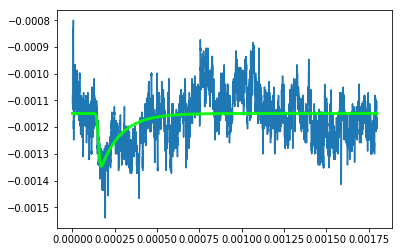

Sigma =  5.3242419676778585e-06
A chi =  14.558603748102913


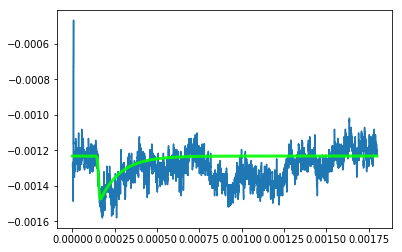

Sigma =  5.4285734049096444e-06
A chi =  56.9966582632268


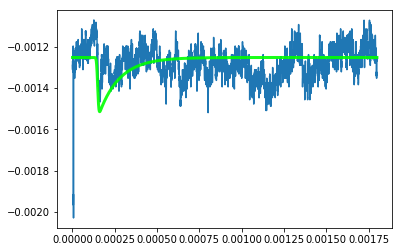

Sigma =  3.2625697366591265e-06
A chi =  16.340964508910496


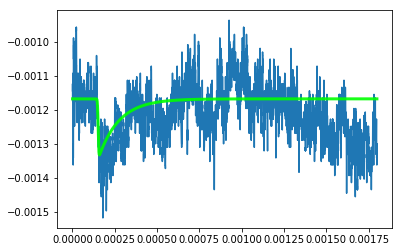

Sigma =  5.4285734049096444e-06
A chi =  33.35736889423473


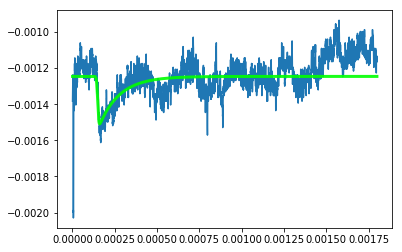

Sigma =  6.594896173797189e-06
A chi =  12.192674917084975


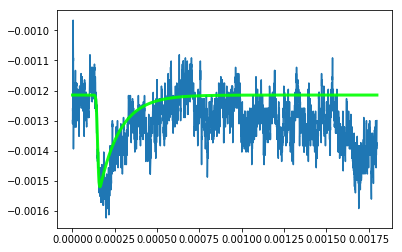

Sigma =  0.00014944722419832875
A chi =  16.494553061106654


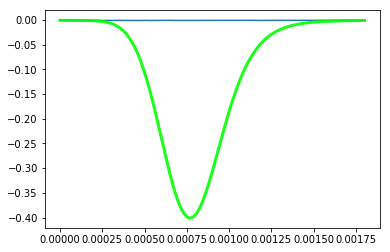

Sigma =  5.43578912454941e-06
A chi =  14.496021122098158


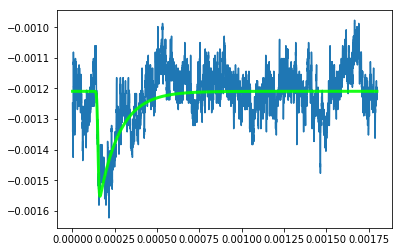

Sigma =  6.160366432426301e-06
A chi =  13.289246520261573


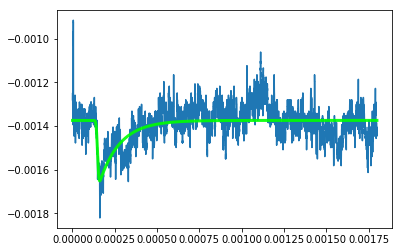

Sigma =  4.8085246755596e-06
A chi =  18.698085060343264


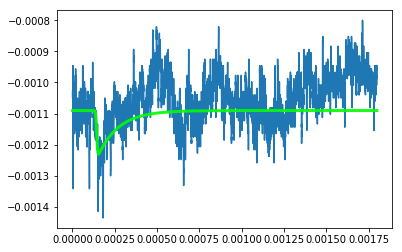

Sigma =  5.4285734049096444e-06
A chi =  92.3792705990419


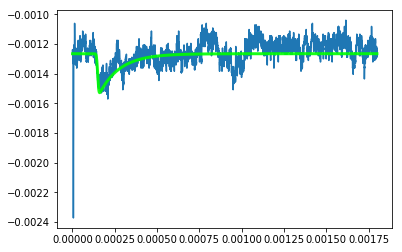

Sigma =  4.756155551129163e-06
A chi =  19.496302697647245


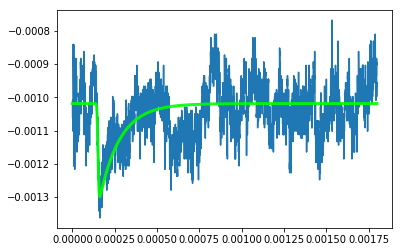

Sigma =  1.0722709977911912e-05
A chi =  19.311915655487226


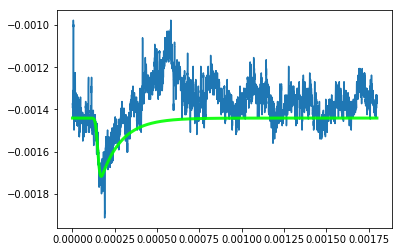

Sigma =  2.808063361349093e-05
A chi =  11.919550942948739


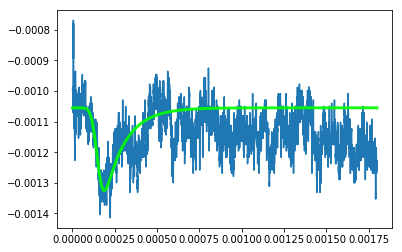

Sigma =  4.496675165094042e-06
A chi =  19.724107271622593


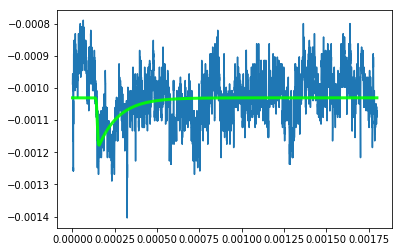

Sigma =  1.0750436126535624e-05
A chi =  16.4472292334194


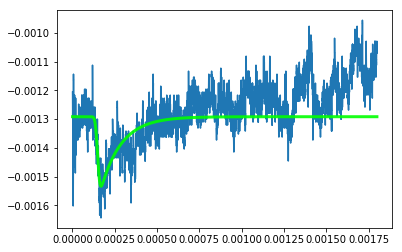

Sigma =  1.8567658818561938e-06
A chi =  12.108565787552193


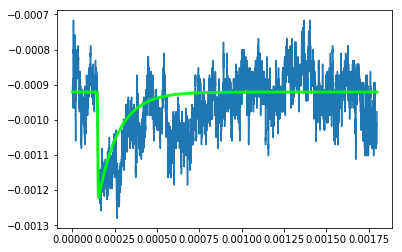

Sigma =  6.973008843847666e-05
A chi =  17.182340525526577


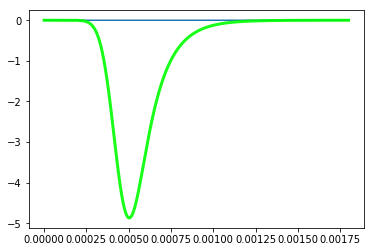

Sigma =  1.3054038162693189e-05
A chi =  13.053066227402928


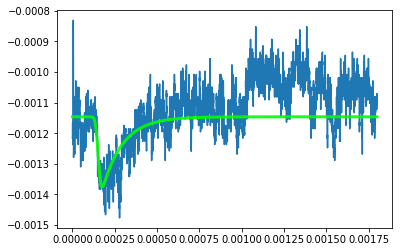

Sigma =  5.342033012872981e-06
A chi =  11.773600991050522


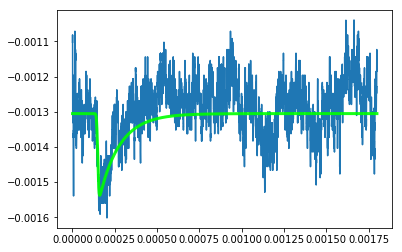

Sigma =  2.7694297580272025e-05
A chi =  25.039468784659235


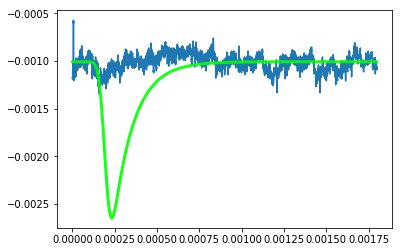

Sigma =  1.0389162649805276e-05
A chi =  11.832559446248995


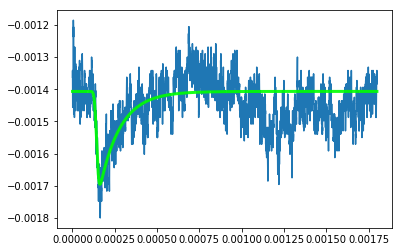

Sigma =  5.4285734049096444e-06
A chi =  14.50188345099028


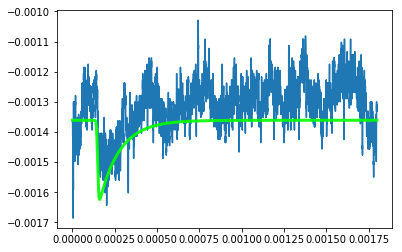

Sigma =  5.4285734049096444e-06
A chi =  15.410382224615097


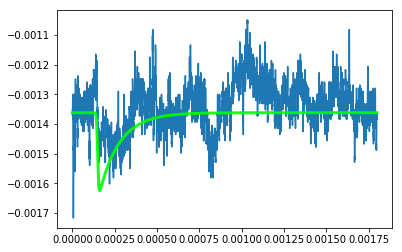

Sigma =  8.916464715284363e-06
A chi =  12.83855310061488


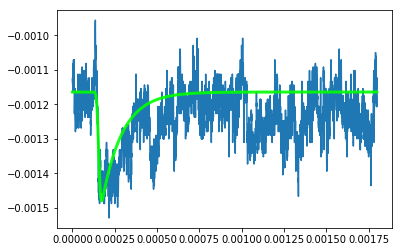

Sigma =  0.00015586121989337226
A chi =  17.439353104902754


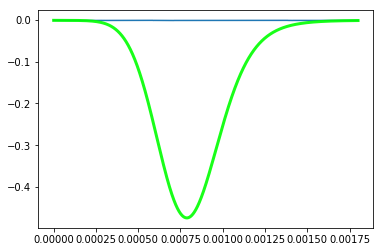

Sigma =  1.1416164929967934e-05
A chi =  17.520072091413564


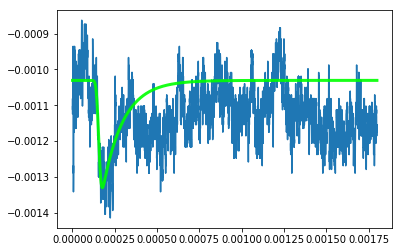

Sigma =  7.880095095837704e-06
A chi =  16.615171496546864


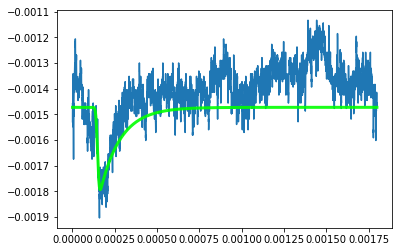

Sigma =  3.838460675434466e-06
A chi =  16.082662686610245


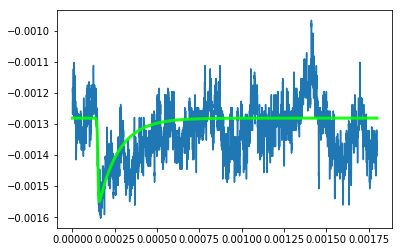

Sigma =  5.4285734049096444e-06
A chi =  14.563988485025648


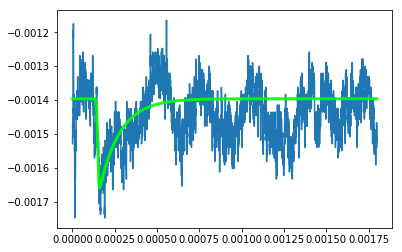

Sigma =  5.4285734049096444e-06
A chi =  41.57186849842538


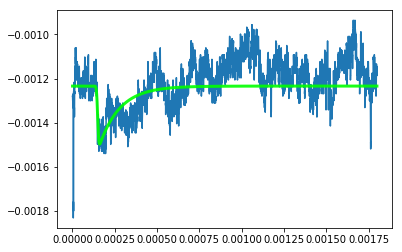

Sigma =  5.189850136110901e-06
A chi =  16.310846103872272


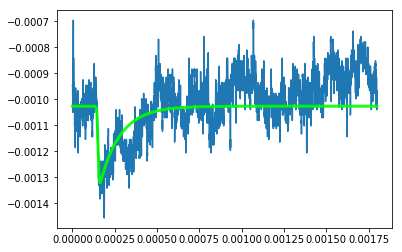

Sigma =  1.9878823600348377e-05
A chi =  12.976576334160951


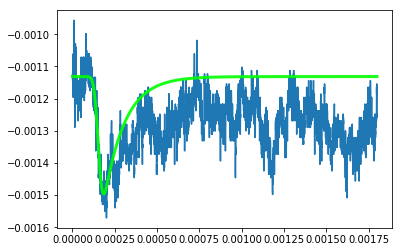

Sigma =  6.1503002235898524e-06
A chi =  17.62620830984974


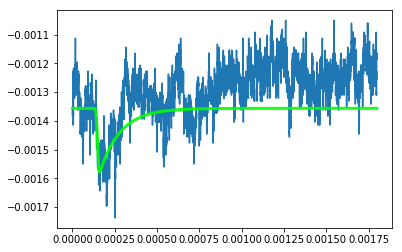

Sigma =  7.491213090281325e-06
A chi =  21.31301193957251


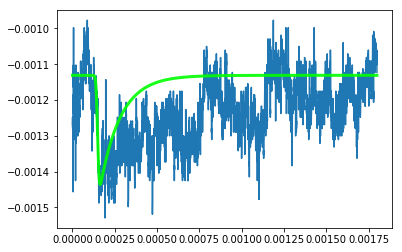

Sigma =  0.00018215927994981874
A chi =  14.814013513392457


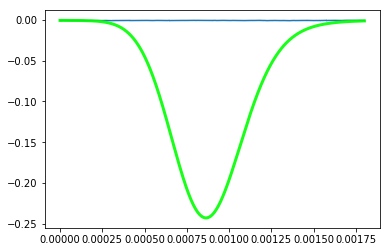

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [150]:
ChG = []
ChS = []
#for per in range(0,len(FOLD)):
for per in [0]:

    #SPATH = '/Users/austinmcdonald/Desktop/XeAr/Data/'+FOLD[per]
    PATH = '/Users/austinmcdonald/Desktop/XeAr/'+FOLD[per]
    folders = glob.glob(PATH+"*/")
    folders.sort()
    
    
    #for F in range(0,len(folders)):
    for F in [1]:
        NAME = folders[F].split('/')[-2]
        print(NAME)
        files = os.listdir(folders[F])
        if '.DS_Store' in files: files.remove('.DS_Store')
        FG,FS = FILE_SORTER(files)
        Yvals = np.zeros(10002)
        Xvals = np.zeros(10002)
        avg = 0
        SIG = []
        CH  =[]
        Clim = 100
        Mx,MEAN = MEAN_WAVEFORM(folders[F],FS)
        plt.plot(Mx,MEAN)
        plt.show(0)
        xs,ys,OPT,chis = FITTER_ANOD(Mx,MEAN)
        for w in range(0,len(FS)):
        #for w in range(0,20):
        #for w in [0]:
            
            X, Y, info = readTrc(folders[F]+FS[w])
            if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
                #plt.plot(X,Y)
                xs,ys,opts,chis = FITTER_ANOD2(X,Y,OPT)
                #print("OPT high G = ",optg)
                print("Sigma = ",opts[1])
                if chis*1e6 <Clim and opts[1]>0:
                    SIG.append(opts[1])
                print("A chi = ",chis*1e6)
                CH.append(chis*1e6)
                plt.plot(xs,ys)
                plt.plot(xs,funcG(xs,*opts),color='lime',alpha=0.9,linewidth=3)
                #plt.xlim(0,.000040)
                plt.show()


In [151]:
SIG = np.array(SIG)*1e6
CH = np.array(CH)

In [152]:
np.mean(SIG)**2

1437.3130257798518

In [153]:
(OPT[1]*1e6)**2

29.46940921249229

In [ ]:
chig

In [ ]:
len(ChG)

In [ ]:
plt.hist(ChG[50],bins=np.linspace(0,10,50),alpha=0.6,label="Gold")
plt.hist(ChS[50],bins=np.linspace(0,10,50),alpha=0.6,label="Anode")
plt.legend(loc="upper right")
plt.xlim(0,6)
plt.axvline(0.75,color="r")
plt.axvline(1,color="lime")
plt.show()

In [ ]:
ChGF = [item for sublist in ChG for item in sublist]
ChSF = [item for sublist in ChS for item in sublist]

In [ ]:
plt.hist(ChGF,bins=np.logspace(-2,4,100),alpha=0.6,label="Gold")
plt.hist(ChSF,bins=np.logspace(-2,4,100),alpha=0.6,label="Anode")
plt.legend(loc="upper right")
plt.loglog()
#plt.xlim(0,6)
#plt.axvline(0.75,color="r")
#plt.axvline(1,color="lime")
#plt.axvline(0.6,color="g")
#plt.axvline(0.8,color="b")
plt.show()
plt.hist(ChGF,bins=np.linspace(0,2,100),alpha=0.6,label="Gold")
plt.hist(ChSF,bins=np.linspace(0,2,100),alpha=0.6,label="Anode")
plt.legend(loc="upper right")
plt.xlim(0,2)
#plt.axvline(0.75,color="r")
plt.axvline(0.7,color="lime")
#plt.axvline(0.6,color="g")
#plt.axvline(0.8,color="b")
plt.show()

In [ ]:
for per in range(0,len(FOLD)):

    SPATH = '/Users/austinmcdonald/Desktop/XeAr/Data-3/'+FOLD[per]
    PATH = '/Users/austinmcdonald/Desktop/XeAr/'+FOLD[per]
    folders = glob.glob(PATH+"*/")
    folders.sort()
    
    CHI = 0.7
    CHI = 20
    for F in range(0,len(folders)):
    #for F in [0]:
        NAME = folders[F].split('/')[-2]
        print(NAME)
        files = os.listdir(folders[F])
        if '.DS_Store' in files: files.remove('.DS_Store')

        FG,FS = FILE_SORTER(files)
        Mx,MEAN = MEAN_WAVEFORM(folders[F],FG)
        Gx,Gy,C = WAVEFORM_QUALITY(folders[F],FG,MEAN,CHI)

        Mx,MEAN = MEAN_WAVEFORM(folders[F],FS)
        Sx,Sy,C = WAVEFORM_QUALITY(folders[F],FS,MEAN,CHI)

        TriggerTime = find_nearest(Sx,0)
        Trigger     = np.where(Sx==TriggerTime)[0][0]
        baselineS    = np.mean(Sy[0:Trigger])
        baselineG    = np.mean(Sy[0:Trigger])
        data = [Gx, Gy-baselineG, Sy-baselineS]
        np.savetxt(SPATH+NAME+'.txt',data)

In [ ]:
MEAN

In [ ]:
FOLD = ['100/','099/','098/','097/','096/','095/','093/','090/','085/']
FF = 1
SPATH = '/Users/austinmcdonald/Desktop/XeHe/Data/'+FOLD[FF]
PATH = '/Users/austinmcdonald/Desktop/XeHe/'+FOLD[FF]
folders = glob.glob(PATH+"*/")
folders.sort()
#folders

In [ ]:
CHI = 1
for F in range(0,len(folders)):
#for F in [0]:
    NAME = folders[F].split('/')[-2]
    print(NAME)
    files = os.listdir(folders[F])
    if '.DS_Store' in files: files.remove('.DS_Store')
    FG,FS = FILE_SORTER(files)
    Mx,MEAN = MEAN_WAVEFORM(folders[F],FG)
    Gx,Gy = WAVEFORM_QUALITY(folders[F],FG,MEAN,CHI)
    
    Mx,MEAN = MEAN_WAVEFORM(folders[F],FS)
    Sx,Sy = WAVEFORM_QUALITY(folders[F],FS,MEAN,CHI)
    
    TriggerTime = find_nearest(Sx,0)
    Trigger     = np.where(Sx==TriggerTime)[0][0]
    baselineS    = np.mean(Sy[0:Trigger])
    baselineG    = np.mean(Sy[0:Trigger])
    data = [Gx, Gy-baselineG, Sy-baselineS]
    np.savetxt(SPATH+NAME+'.txt',data)

In [ ]:
Sx,Sy = WAVEFORM_QUALITY(folders[F],FS,MEAN,CHI)
Sx

In [ ]:
EH = []
PATH = folders[F]
files = FS
Yvals = np.zeros(10002)
Xvals = np.zeros(10002)
avg = 0
#for w in range(0,1100):
for w in range(0,len(files)):

    X, Y, info = readTrc(PATH+files[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        A = moving_average(MEAN,10)
        B = moving_average(Y   ,10)
        D = moving_average(X   ,10)
        TriggerTime = find_nearest(D,0)
        Trigger     = np.where(D==TriggerTime)[0][0]
        As    = np.mean(A[:Trigger])
        Bs    = np.mean(B[:Trigger])

        holder = ((A-As)-(B-Bs))**2
        chi = np.sum(holder)*1e4
        EH.append(chi)
        if chi <100:
            Yvals += Y
            Xvals += X
            avg   += 1
    SigY = Yvals/avg
    SigX = Xvals/avg

In [ ]:
plt.plot(SigX,SigY)

In [ ]:
plt.hist(EH)

In [ ]:
EH = []
CHI = 2
#for F in range(0,len(folders)):
AHHH = "/Users/austinmcdonald/Desktop/XeHe/099/Xe-099_P-10_E-350/"
#print(folders[F])
NAME = AHHH.split('/')[-2]
print(NAME)
files = os.listdir(AHHH)
FG,FS = FILE_SORTER(files)
Mx,MEAN = MEAN_WAVEFORM(AHHH,FS)



X, Y, info = readTrc(AHHH+FS[1])
Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
#for w in range(0,1100):
for w in range(0,len(FS)):

    X, Y, info = readTrc(AHHH+FS[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        A = moving_average(MEAN,10)
        B = moving_average(Y   ,10)
        D = moving_average(X   ,10)
        TriggerTime = find_nearest(D,0)
        Trigger     = np.where(D==TriggerTime)[0][0]
        As    = np.mean(A[0:Trigger])
        Bs    = np.mean(B[0:Trigger])

        holder = ((A-As)-(B-Bs))**2
        chi = np.sum(holder)*1e4
        print(chi)
        plt.figure(figsize=(6,6))
        plt.plot(D,A-As)
        plt.plot(D,B-Bs)
        plt.show()

        EH.append(chi)

        if chi <3:
            Yvals += Y
            Xvals += X
            avg   += 1
    SigY = Yvals/avg
    SigX = Xvals/avg



In [ ]:
TriggerTime = find_nearest(SigX,0)
Trigger     = np.where(SigX==TriggerTime)[0][0]

In [ ]:
Trigger

In [ ]:
plt.plot(SigX,SigY)

In [ ]:
files = os.listdir(AHHH)
FG,FS = FILE_SORTER(files)

#X, Y, info = readTrc(AHHH+FG[0])
#Yvals = np.zeros(X.shape[0])
#Xvals = np.zeros(Y.shape[0])
Yvals = np.zeros(10002)
Xvals = np.zeros(10002)
avg = 0
for w in range(0,len(FG)):

    X, Y, info = readTrc(AHHH +FG[w])
    print(X.shape)

    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        Yvals += Y
        Xvals += X
        avg   += 1
MSigY = Yvals/avg
MSigX = Xvals/avg

In [ ]:
Xvals.shape

In [ ]:
plt.plot(MSigX,MSigY)

In [ ]:
SPATH = '/Users/austinmcdonald/Desktop/Xenon/Data/100-2/'
PATH = '/Users/austinmcdonald/Desktop/Xenon/100-2/'
folders = glob.glob(PATH+"*/")
folders.sort()
folders

In [ ]:
len(folders)

In [ ]:
CHI = 2
for F in range(0,len(folders)):
    #print(folders[F])
    NAME = folders[F].split('/')[-2]
    print(NAME)
    files = os.listdir(folders[F])
    
    FilesGold   = []
    FilesSignal = []

    for x in range(0,len(files)):
        if int(files[x][1]) ==4 or int(files[x][1]) ==2:
            FilesGold.append(files[x])
        if int(files[x][1]) ==3 or int(files[x][1]) ==1:
            FilesSignal.append(files[x])
            
    X, Y, info = readTrc(folders[F]+FilesSignal[0])
    Yvals = np.zeros(X.shape[0])
    Xvals = np.zeros(Y.shape[0])
    avg = 0
    for w in range(0,len(FilesSignal)):

        X, Y, info = readTrc(folders[F]+FilesSignal[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            Yvals += Y
            Xvals += X
            avg   += 1
    MSigY = Yvals/avg
    MSigX = Xvals/avg
    
    
    X, Y, info = readTrc(folders[F]+FilesSignal[0])
    Yvals = np.zeros(X.shape[0])
    Xvals = np.zeros(Y.shape[0])
    avg = 0
    #for w in range(0,1100):
    for w in range(0,len(FilesSignal)):

        X, Y, info = readTrc(folders[F]+FilesSignal[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            CC = moving_average((MSigY-Y),1)
            xx = moving_average(X,50)
            chiH = CC**2
            chi = np.sum(chiH)*1000
            if chi <CHI:
                mm.append(chi)
                Yvals += Y
                Xvals += X
                avg   += 1
    SigY = Yvals/avg
    SigX = Xvals/avg
    print("Sig avg",avg)

    
    X, Y, info = readTrc(folders[F]+FilesGold[0])

    avg = 0
    for w in range(0,len(FilesGold)):

        X, Y, info = readTrc(folders[F]+FilesGold[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            Yvals += Y
            Xvals += X
            avg   += 1
    MGolY = Yvals/avg
    MGolX = Xvals/avg
    
    
    X, Y, info = readTrc(folders[F]+FilesGold[0])  
    Yvals = np.zeros(X.shape[0])
    Xvals = np.zeros(Y.shape[0])
    avg = 0 
    #for w in range(0,1100):
    for w in range(0,len(FilesGold)):
        X, Y, info = readTrc(folders[F]+FilesGold[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            CC = moving_average((MGolY-Y),1)
            xx = moving_average(X,50)
            EE = np.mean(CC)
            chiH = (CC-EE)**2
            chi = np.sum(chiH)*1000
            if chi <CHI:
                mm.append(chi)
                Yvals += Y
                Xvals += X
                avg   += 1
    GolY = Yvals/avg
    GolX = Xvals/avg
    print("Gol avg",avg)


    TriggerTime = find_nearest(SigX,0)
    Trigger     = np.where(SigX==TriggerTime)[0][0]
    baselineS    = np.mean(SigY[0:Trigger])
    baselineG    = np.mean(GolY[0:Trigger])
    data = [(GolX), GolY-baselineG, SigY-baselineS]
    np.savetxt(SPATH+NAME+'.txt',data)
    #print("DONE!")

In [ ]:
def FILE_SORTER(files):
    FilesGold   = []
    FilesSignal = []
    for x in range(0,len(files)):
        if int(files[x][1]) ==4 or int(files[x][1]) ==2:
            FilesGold.append(files[x])
        if int(files[x][1]) ==3 or int(files[x][1]) ==1:
            FilesSignal.append(files[x])
            
    FilesGold.sort(); FilesSignal.sort()
    return FilesGold, FilesSignal

def MEAN_WAVEFORM(PATH,files):
    #folders[F]+FilesSignal[0]
    X, Y, info = readTrc(PATH+files[0])
    Yvals = np.zeros(X.shape[0])
    Xvals = np.zeros(Y.shape[0])
    avg = 0
    for w in range(0,len(files)):

        X, Y, info = readTrc(PATH+files[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            Yvals += Y
            Xvals += X
            avg   += 1
    MSigY = Yvals/avg
    MSigX = Xvals/avg
    return MSigX,MSigY

def WAVEFORM_QUALITY(PATH,files,MEAN,CHI):
    
    X, Y, info = readTrc(PATH+files[0])
    Yvals = np.zeros(X.shape[0])
    Xvals = np.zeros(Y.shape[0])
    avg = 0
    #for w in range(0,1100):
    for w in range(0,len(files)):

        X, Y, info = readTrc(PATH+files[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            A = moving_average(MEAN,10)
            B = moving_average(Y   ,10)
            D = moving_average(X   ,10)
            TriggerTime = find_nearest(D,0)
            Trigger     = np.where(D==TriggerTime)[0][0]
            As    = np.mean(A[0:Trigger])
            Bs    = np.mean(B[0:Trigger])
            
            holder = ((A-As)-(B-Bs))**2
            chi = np.sum(holder)*1e4
            if chi <CHI:
                Yvals += Y
                Xvals += X
                avg   += 1
        SigY = Yvals/avg
        SigX = Xvals/avg
    return SigX,SigY

In [ ]:
FG,FS = FILE_SORTER(files)

In [ ]:
Mx,My = MEAN_WAVEFORM(folders[F],FG)

In [ ]:
FOLD = '100/'
SPATH = '/Users/austinmcdonald/Desktop/XeAr/Data/'+FOLD
PATH = '/Users/austinmcdonald/Desktop/XeAr/'+FOLD
folders = glob.glob(PATH+"*/")
folders.sort()
#folders

In [ ]:
CHI = 1
for F in range(0,len(folders)):
#for F in [0]:
    NAME = folders[F].split('/')[-2]
    print(NAME)
    files = os.listdir(folders[F])
    FG,FS = FILE_SORTER(files)
    Mx,MEAN = MEAN_WAVEFORM(folders[F],FG)
    Gx,Gy = WAVEFORM_QUALITY(folders[F],FG,MEAN,CHI)
    
    Mx,MEAN = MEAN_WAVEFORM(folders[F],FS)
    Sx,Sy = WAVEFORM_QUALITY(folders[F],FS,MEAN,CHI)
    
    TriggerTime = find_nearest(Sx,0)
    Trigger     = np.where(Sx==TriggerTime)[0][0]
    baselineS    = np.mean(Sy[0:Trigger])
    baselineG    = np.mean(Sy[0:Trigger])
    data = [Gx, Gy-baselineG, Sy-baselineS]
    np.savetxt(SPATH+NAME+'.txt',data)

In [ ]:
plt.plot(Sx,Sy)

In [ ]:
EH = []
CHI = 2
#for F in range(0,len(folders)):
for F in [0]:

#print(folders[F])
    NAME = '/Users/austinmcdonald/Desktop/XeAr/100/Xe-100_P-09_E-200/'.split('/')[-2]
    print(NAME)
    files = os.listdir('/Users/austinmcdonald/Desktop/XeAr/100/Xe-100_P-09_E-200/')
    FG,FS = FILE_SORTER(files)
    Mx,MEAN = MEAN_WAVEFORM('/Users/austinmcdonald/Desktop/XeAr/100/Xe-100_P-09_E-200/',FG)
    
    
    
    X, Y, info = readTrc('/Users/austinmcdonald/Desktop/XeAr/100/Xe-100_P-09_E-200/'+FG[1])
    Yvals = np.zeros(X.shape[0])
    Xvals = np.zeros(Y.shape[0])
    avg = 0
    #for w in range(0,1100):
    for w in range(0,len(FS)):

        X, Y, info = readTrc('/Users/austinmcdonald/Desktop/XeAr/100/Xe-100_P-09_E-200/'+FG[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            A = moving_average(MEAN,10)
            B = moving_average(Y   ,10)
            D = moving_average(X   ,10)
            TriggerTime = find_nearest(D,0)
            Trigger     = np.where(D==TriggerTime)[0][0]
            As    = np.mean(A[0:Trigger])
            Bs    = np.mean(B[0:Trigger])
            
            holder = ((A-As)-(B-Bs))**2
            chi = np.sum(holder)*1e4
            print(chi)
            plt.figure(figsize=(6,6))
            plt.plot(D,A-As)
            plt.plot(D,B-Bs)
            plt.show()
        
            EH.append(chi)

            if chi <1:
                mm.append(chi)
                Yvals += Y
                Xvals += X
                avg   += 1
        SigY = Yvals/avg
        SigX = Xvals/avg
            


In [ ]:
MEAN

In [ ]:
np.linspace(0,1,10)

In [ ]:
plt.hist(EH,bins=np.linspace(0,10,100))
plt.show()

In [ ]:
plt.plot(SigX,SigY)
plt.plot(Sx,Sy)

In [ ]:
eh = '/Users/austinmcdonald/Desktop/Xenon/100-2/Xe-100_P-11_E-100/C1electron00026.trc'
X, Y, info = readTrc(eh)
plt.plot(X,Y,color='g')


In [ ]:
TriggerTime = find_nearest(GolX,0)
Trigger     = np.where(GolX==TriggerTime)[0][0]+35

T2 = find_nearest(GolX,0.00125)
T2 = np.where(GolX==T2)[0][0]
plt.plot(GolX,GolY,color='g')
plt.plot(SigX,SigY,color='r')
plt.plot(GolX[Trigger:T2],GolY[Trigger:T2],color='k')
#plt.xlim(-0.00001,0.00001)

In [ ]:
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+20

In [ ]:
Trigger

In [ ]:
T2

In [ ]:
[1034:7249]

In [ ]:
mm=[]
F=-1
files = os.listdir(folders[F])

FilesGold   = []
FilesSignal = []

for x in range(0,len(files)):
    if int(files[x][1]) ==4 or int(files[x][1]) ==2:
        FilesGold.append(files[x])
    if int(files[x][1]) ==3 or int(files[x][1]) ==1:
        FilesSignal.append(files[x])

X, Y, info = readTrc(folders[F]+FilesGold[0])

Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
for w in range(0,len(FilesSignal)):

    X, Y, info = readTrc(folders[F]+FilesGold[w])

    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        Yvals += Y
        Xvals += X
        avg   += 1
MSigY = Yvals/avg
MSigX = Xvals/avg


X, Y, info = readTrc(folders[F]+FilesGold[0])

Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
#for w in range(0,11):
for w in range(0,len(FilesGold)):

    X, Y, info = readTrc(folders[F]+FilesGold[w])

    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        CC = moving_average((MSigY-Y),1)
        xx = moving_average(X,1)
        EE = np.mean(CC)
        chiH = (CC-EE)**2
        chi = np.sum(chiH)*1000

        #coefs = poly.polyfit(xx, CC, 1)
        #ffit = poly.polyval(xx, coefs)
        #chi = abs(chisquare(CC, f_exp=ffit)[0])
        print(chi)
  
        plt.plot(xx,CC)
        #plt.plot(xx,ffit)

        plt.show()
        mm.append(chi)
        if chi <1:
            #mm.append(chi)
            Yvals += Y
            Xvals += X
            avg   += 1
SigY = Yvals/avg
SigX = Xvals/avg
print("Sig avg",avg)

In [ ]:
plt.hist(mm,bins=np.linspace(0,10,100))
plt.show()

In [ ]:
plt.plot(SigX,SigY)
#plt.plot(MSigX,MSigY)

In [ ]:
plt.plot(SigX,MSigY-SigY)
#plt.plot(MSigX,MSigY)

In [ ]:
plt.plot(MSigX[Trigger:T2],MSigY[Trigger:T2])

In [ ]:
from scipy import stats
from scipy.stats import chisquare
import numpy.polynomial.polynomial as poly

#slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

In [ ]:
import numpy.polynomial.polynomial as poly

#coefs = poly.polyfit(x, y, 4)
#ffit = poly.polyval(x_new, coefs)

In [ ]:
F=-1   #print(folders[F])
NAME = folders[F].split('/')[-2]
NAME

In [ ]:
F = 3
files = os.listdir(folders[F])

FilesGold   = []
FilesSignal = []

for x in range(0,len(files)):
    if int(files[x][1]) ==4 or int(files[x][1]) ==2:
        FilesGold.append(files[x])
    if int(files[x][1]) ==3 or int(files[x][1]) ==1:
        FilesSignal.append(files[x])
mm=[]

X, Y, info = readTrc(folders[F]+FilesGold[0])




avg = 0
for w in range(0,len(FilesGold)):

    X, Y, info = readTrc(folders[F]+FilesGold[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        Yvals += Y
        Xvals += X
        avg   += 1
MGolY = Yvals/avg
MGolX = Xvals/avg


X, Y, info = readTrc(folders[F]+FilesGold[0])  


Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
#for w in range(0,10):
for w in range(0,len(FilesGold)):
    X, Y, info = readTrc(folders[F]+FilesGold[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        CC = moving_average((MGolY-Y),50)
        xx = moving_average(X,50)
        coefs = poly.polyfit(xx, CC, 1)
        ffit = poly.polyval(xx, coefs)
        chi = abs(chisquare(CC, f_exp=ffit)[0])
        print(chi)
        plt.plot(xx,CC)
        plt.plot(xx,ffit)
        plt.show()
        mm.append(chi)

        if chi <0.5:
            #mm.append(chi)
            Yvals += Y
            Xvals += X
            avg   += 1
GGolY = Yvals/avg
GGolX = Xvals/avg

In [ ]:
avg

In [ ]:
plt.plot(GolX,GolY,alpha=0.4)
plt.plot(GGolX,GGolY,color='r')


In [ ]:
plt.plot(GolX,GolY,alpha=0.4)


In [ ]:
#SSigX3 =SSigX
#SSigY3 =SSigY

plt.plot(SSigX,SSigY,color='r')

plt.plot(SigX,SigY,alpha=0.4)


In [ ]:
plt.plot(SigX,SigY-Y)
plt.plot(X,Y)

In [ ]:
np.linspace(0,10,100)

In [ ]:
plt.hist(mm,bins=np.linspace(0,10,100))
plt.show()

In [ ]:
mm

In [ ]:
AH = 3
files = os.listdir(folders[AH])
len(files)

In [ ]:
FilesGold   = []
FilesSignal = []

for x in range(0,len(files)):
    if int(files[x][1]) ==4 or int(files[x][1]) ==2:
        FilesGold.append(files[x])
    if int(files[x][1]) ==3 or int(files[x][1]) ==1:
        FilesSignal.append(files[x])

In [ ]:
X, Y, info = readTrc(folders[AH]+FilesSignal[0])

Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
#for w in range(0,1100):
for w in range(0,len(FilesSignal)):

    X, Y, info = readTrc(folders[AH]+FilesSignal[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        Yvals += Y
        Xvals += X
        avg   += 1
SigY = Yvals/avg
SigX = Xvals/avg

X, Y, info = readTrc(folders[AH]+FilesGold[0])

Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
#for w in range(0,1100):
for w in range(0,len(FilesGold)):
    X, Y, info = readTrc(folders[AH]+FilesGold[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        Yvals += Y
        Xvals += X
        avg   += 1
GolY = Yvals/avg
GolX = Xvals/avg

In [ ]:
TriggerTime = find_nearest(SigX,0)
Trigger     = np.where(SigX==TriggerTime)[0][0]
baselineS    = np.mean(SigY[0:Trigger])
baselineG    = np.mean(GolY[0:Trigger])
data = [GolX, GolY-baselineG, SigY-baselineS]
np.savetxt(PATH+"test"+'.txt',data)

In [ ]:
plt.plot(GolX,SigY-baselineS+0.001)
plt.plot(GolX,GolY-baselineG)

In [ ]:
AH = 3
Fold = folders[AH].split('/')[-2]
cut = Fold+'/'



files = os.listdir(folders[AH])
#files.remove('.DS_Store')
int(files[4][1])

In [ ]:
Fold

In [ ]:
FilesGold   = []
FilesSignal = []

for x in range(0,len(files)):
    if int(files[x][1]) ==4 or int(files[x][1]) ==2:
        FilesGold.append(files[x])
    if int(files[x][1]) ==3 or int(files[x][1]) ==1:
        FilesSignal.append(files[x])

In [ ]:
X, Y, info = readTrc(folders[AH]+FilesSignal[0])

Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
#for w in range(0,1100):
for w in range(0,len(FilesSignal)):

    X, Y, info = readTrc(folders[AH]+FilesSignal[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        Yvals += Y
        Xvals += X
        avg   += 1
SigY = Yvals/avg
SigX = Xvals/avg

In [ ]:
avg

In [ ]:
TriggerTime = find_nearest(SigX,0)
Trigger     = np.where(SigX==TriggerTime)[0][0]
baseline    = np.mean(SigY[0:Trigger])
data = [SigX,SigY-baseline]
np.savetxt('/Users/austinmcdonald/Desktop/Xenon-11bar-test/'+"Sig-"+Fold+'.txt',data)

In [ ]:
X, Y, info = readTrc(folders[AH]+FilesGold[1])

Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
#for w in range(0,1100):
for w in range(0,len(FilesGold)):
    X, Y, info = readTrc(folders[AH]+FilesGold[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        Yvals += Y
        Xvals += X
        avg   += 1
GolY = Yvals/avg
GolX = Xvals/avg

In [ ]:
avg

In [ ]:
TriggerTime = find_nearest(GolX,0)
Trigger     = np.where(GolX==TriggerTime)[0][0]
baseline    = np.mean(GolY[0:Trigger])
data = [GolX,GolY-baseline]
np.savetxt('/Users/austinmcdonald/Desktop/Xenon-11bar-test/'+"Gol-"+Fold+'.txt',data)

In [ ]:
for q in range(3,4):
    files = os.listdir(folders[q])
    Name = folders[q].split('/')[-2]
    N = len(files)
    
    X, Y, info = readTrc(folders[q]+files[0])
    
    Yvals = np.zeros(X.shape[0])
    Xvals = np.zeros(Y.shape[0])
    avg = 0
    for w in range(0,N):
        X, Y, info = readTrc(folders[q]+files[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            Yvals += Y
            Xvals += X
            avg   += 1
    Yvals = Yvals/avg
    Xvals = Xvals/avg
    TriggerTime = find_nearest(Xvals,0)
    Trigger     = np.where(Xvals==TriggerTime)[0][0]
    baseline    = np.mean(Yvals[0:Trigger])
    data = [Xvals,Yvals-baseline]
    np.savetxt(PATH+Name+'.txt',data)
    
    

In [ ]:
Yvals

In [ ]:
files = os.listdir()
#files.remove('.DS_Store')


In [ ]:
len(files)

In [ ]:
N = len(files)
Yvals = np.zeros(50e3+2)
Xvals = np.zeros(50e3+2)

for q in range(0,N):
    X, Y, info = readTrc(files[q])
    #Y = np.array(Y)
    Yvals += Y
    Xvals +=X
Yvals = Yvals/N
Xvals = Xvals/N

In [ ]:
find_nearest(Xvals,0)

In [ ]:
TriggerTime = find_nearest(Xvals,0)
Trigger     = np.where(Xvals==TriggerTime)[0][0]
baseline    = np.mean(Yvals[0:Trigger])
baseline

In [ ]:
plt.plot(Xvals,Yvals-baseline)

In [ ]:
data = [Xvals,Yvals-baseline]

In [ ]:
path = '/Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/090418-cleaned-2bar/'
np.savetxt(path+'050-clean.txt',data)

In [ ]:
AA = np.loadtxt(path+'200clean.txt')
